# JPR 2020 RR notebook

This is the version of the 'master' notebook that produced results for the resubmission of the JPR 2020 article.

In [1]:
import logging
import itertools
import multiprocessing as mp
import os
import json
import time
import copy

import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from views.apps.plot.maps.fancy import fancy
from views.apps.ensemble import ensemble as ens, calibrate
from views.apps.ensemble import plots as ep
from views.apps.model import model as mod 
from views.apps.evaluate import evaluation, eval_tex, eval_plot, eval_data, eval_lib
from views.apps.evaluate import feature_importance as fi
from views.utils import datautils, dbutils, pyutils, config

In [2]:
notebook_timer_start = time.time()

In [3]:
%matplotlib inline

In [4]:
logging.basicConfig(format=pyutils.LOGFORMAT, level=logging.INFO)
Logger = logging.getLogger(__name__)

In [5]:
# Set notebook width to fill browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# INITIAL SETUP <a name="initial_setup"></a>

In [6]:
# Meta-data
run_id = "JPR 2020"

In [7]:
# Feature switches

# Set True to delete dir_output and start fresh
delete_output_start_fresh = False

# Set False to use cached data files
refetch_data_from_db = False

# Leave off, ablation already worked in to ensembles I think.
do_ablation = False

# Leave on, at least for first run.
do_prediction_maps = False 

# Leave off, requires locally synced runs. 
# The function that reads the existing feature importance scores from database always runs.
redo_featimp = False 

# Plot calibration curve per constituent model step
plot_calibration_ss = True

## Choose output directory

In [8]:
# Setup a cache directory for data so we can restart the notebook
# in 5s instead of 20 minutes in case we mess up the data
dir_scratch = config.CONFIG['dirs']['dir_scratch']
dir_cache = os.path.join(dir_scratch, "cache", "jpr_2020")
pyutils.create_dir(dir_cache)

# Setup output directory structure
#dir_output = os.path.join(dir_scratch, "output", "jpr_2020")
# Håvard: set this to overleaf dropbox dir to write output directly to overleaf.
dir_output = "/Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/" 

if delete_output_start_fresh:
    pyutils.delete_dir(dir_output)

dir_plots = os.path.join(dir_output, "plots")
dir_plots_pies = os.path.join(dir_output, "plots", "pies")
dir_plots_stacks = os.path.join(dir_output, "plots", "stacks")
dir_plots_corr_pgm = os.path.join(dir_output, "plots", "corr", "pgm")
dir_plots_corr_cm = os.path.join(dir_output, "plots", "corr", "cm")
dir_plots_maps_pgm = os.path.join(dir_output, "plots", "maps", "pgm")
dir_plots_maps_cm = os.path.join(dir_output, "plots", "maps", "cm")
dir_plots_diagnostic_cm = os.path.join(dir_output, "plots", "diagnostic", "cm")
dir_plots_diagnostic_pgm = os.path.join(dir_output, "plots", "diagnostic", "pgm")
dir_plots_heatmaps_cm = os.path.join(dir_output, "plots", "heatmaps", "cm")
dir_plots_heatmaps_pgm = os.path.join(dir_output, "plots", "heatmaps", "pgm")
dir_plots_spaghetti_cm = os.path.join(dir_output, "plots", "spaghetti", "cm")
dir_plots_featimps_cm = os.path.join(dir_output, "plots", "featimp", "cm")
dir_plots_featimps_pgm = os.path.join(dir_output, "plots", "featimp", "pgm")
dir_plots_deltas_cm = os.path.join(dir_output, "plots", "deltas", "cm")
dir_plots_deltas_pgm = os.path.join(dir_output, "plots", "deltas", "pgm")
dir_plots_calibration_cm = os.path.join(dir_output, "plots", "calibration", "cm")
dir_plots_lines_cm = os.path.join(dir_output, "plots", "lines", "cm")
dir_plots_lines_pgm = os.path.join(dir_output, "plots", "lines", "pgm")

pyutils.create_dir(dir_plots)
pyutils.create_dir(dir_plots_pies)
pyutils.create_dir(dir_plots_stacks)
pyutils.create_dir(dir_plots_corr_pgm)
pyutils.create_dir(dir_plots_corr_cm)
pyutils.create_dir(dir_plots_maps_pgm)
pyutils.create_dir(dir_plots_maps_cm)
pyutils.create_dir(dir_plots_diagnostic_cm)
pyutils.create_dir(dir_plots_diagnostic_pgm)
pyutils.create_dir(dir_plots_heatmaps_cm)
pyutils.create_dir(dir_plots_heatmaps_pgm)
pyutils.create_dir(dir_plots_spaghetti_cm)
pyutils.create_dir(dir_plots_featimps_cm)
pyutils.create_dir(dir_plots_featimps_pgm)
pyutils.create_dir(dir_plots_deltas_cm)
pyutils.create_dir(dir_plots_deltas_pgm)
pyutils.create_dir(dir_plots_calibration_cm)
pyutils.create_dir(dir_plots_lines_cm)
pyutils.create_dir(dir_plots_lines_pgm)

dir_featimps_pgm = os.path.join(dir_output, "feature_importance", "pgm")
dir_featimps_cm = os.path.join(dir_output, "feature_importance", "cm")
pyutils.create_dir(dir_featimps_pgm)
pyutils.create_dir(dir_featimps_cm)

dir_tables = os.path.join(dir_output, "tables")
dir_tables_eval = os.path.join(dir_output, "tables", "eval")
dir_tables_eval_weights = os.path.join(dir_output, "tables", "eval", "weights")
dir_tables_eval_ensembles = os.path.join(dir_output, "tables", "eval", "ensembles")
dir_tables_eval_ensembles_oldvsnew = os.path.join(dir_output, "tables", "eval", "ensembles", "oldvsnew")
dir_tables_eval_ensembles_ebmavsunweighted = os.path.join(dir_output, "tables", "eval", "ensembles", "ebmavsunweighted")
dir_tables_eval_ensembles_onset = os.path.join(dir_output, "tables", "eval", "ensembles", "onset")
dir_tables_eval_ensembles_incidence = os.path.join(dir_output, "tables", "eval", "ensembles", "incidence")
dir_tables_eval_ensembles_compare_onset = os.path.join(dir_output, "tables", "eval", "ensembles", "compare_onset")
dir_tables_eval_ensembles_compare_incidence = os.path.join(dir_output, "tables", "eval", "ensembles", "compare_incidence")
dir_tables_eval_ensembles_incidencevsonset = os.path.join(dir_output, "tables", "eval", "ensembles", "incidencevsonset")
dir_tables_eval_constituent = os.path.join(dir_output, "tables", "eval", "constituent")
dir_tables_eval_constituent_onset = os.path.join(dir_output, "tables", "eval", "constituent", "onset")
dir_tables_eval_constituent_incidence = os.path.join(dir_output, "tables", "eval", "constituent", "incidence")
dir_tables_eval_constituent_compare_onset = os.path.join(dir_output, "tables", "eval", "constituent", "compare_onset")
dir_tables_eval_constituent_compare_incidence = os.path.join(dir_output, "tables", "eval", "constituent", "compare_incidence")
dir_tables_eval_constituent_incidencevsonset = os.path.join(dir_output, "tables", "eval", "constituent", "incidencevsonset")

dir_tables_featimp_cm = os.path.join(dir_output, "tables", "featimp", "cm")
dir_tables_featimp_pgm = os.path.join(dir_output, "tables", "featimp", "pgm")

pyutils.create_dir(dir_tables)
pyutils.create_dir(dir_tables_eval)
pyutils.create_dir(dir_tables_eval_weights)
pyutils.create_dir(dir_tables_eval_ensembles)
pyutils.create_dir(dir_tables_eval_ensembles_oldvsnew)
pyutils.create_dir(dir_tables_eval_ensembles_ebmavsunweighted)
pyutils.create_dir(dir_tables_eval_ensembles_onset)
pyutils.create_dir(dir_tables_eval_ensembles_incidence)
pyutils.create_dir(dir_tables_eval_ensembles_compare_onset)
pyutils.create_dir(dir_tables_eval_ensembles_compare_incidence)
pyutils.create_dir(dir_tables_eval_ensembles_incidencevsonset)

pyutils.create_dir(dir_tables_eval_constituent)
pyutils.create_dir(dir_tables_eval_constituent_onset)
pyutils.create_dir(dir_tables_eval_constituent_incidence)
pyutils.create_dir(dir_tables_eval_constituent_compare_onset)
pyutils.create_dir(dir_tables_eval_constituent_compare_incidence)
pyutils.create_dir(dir_tables_eval_constituent_incidencevsonset)
pyutils.create_dir(dir_tables_featimp_cm)
pyutils.create_dir(dir_tables_featimp_pgm)

In [9]:
dir_tables_eval_ensembles_ablation = os.path.join(dir_output, "tables", "eval", "ensembles", "ablation")
pyutils.create_dir(dir_tables_eval_ensembles_ablation)

In [10]:
# Set ids and actuals cols
ids_pgm = ["month_id", "pg_id"]
ids_cm = ["month_id", "country_id"]
cols_actuals = [
    "ged_tx_sb_25",
    "ged_tx_ns_25",
    "ged_tx_os_25",
    "ged_dummy_sb",
    "ged_dummy_ns",
    "ged_dummy_os",
    "onset24_tx_sb_1",
    "onset24_tx_ns_1",
    "onset24_tx_os_1",
    "onset24_tx_sb_5",
    "onset24_tx_ns_5",
    "onset24_tx_os_5",
    "onset24_tx_sb_25",
    "onset24_tx_ns_25",
    "onset24_tx_os_25"
]
periods = {
    "a": {"start": 397, "end": 433},
    "b": {"start": 433, "end": 468},
    "c": {"start": 481, "end": 518},
}

In [11]:
%%time
# Get mapdata for plotting
mapdata = fancy.MapData()

# GET DATA <a name="get_data"></a>

In [12]:
def get_globally_trained():
    """ Get predictions from global training notebook"""
    
    def fix_global_names(df):
        for modeltemplate in ['wdi_all', 'vdem', 'reign', 'all']:
            for step in [1, 3, 6, 12, 24, 36]:
                for outcome in ["sb", "ns", "os"]:
                    col_to_rename = 'ss.' + modeltemplate + '_' + outcome + '.' + str(step)
                    renamed = 'ss.' + outcome + '_'  + modeltemplate + '_glob' + '.' + str(step)
                    df.rename(columns={col_to_rename: renamed}, inplace=True)

        return df
    
    # Get predictions from HH Model development notebook
    df_a = dbutils.db_to_df(
            fqtable="newpipe.cm_hh_a_predict_fh",
            ids=["month_id", "country_id"],
            columns=[
                col for col in dbutils.list_columns("newpipe.cm_hh_a_predict_fh") if col.startswith("ss.")
            ],
        )

    df_b = dbutils.db_to_df(
            fqtable="newpipe.cm_hh_b_predict_fh",
            ids=["month_id", "country_id"],
            columns=[
                col for col in dbutils.list_columns("newpipe.cm_hh_b_predict_fh") if col.startswith("ss.")
            ],
        )
    df_c = dbutils.db_to_df(
            fqtable="newpipe.cm_hh_c_predict_r_2020_02_02",
            ids=["month_id", "country_id"],
            columns=[
                col for col in dbutils.list_columns("newpipe.cm_hh_c_predict_r_2020_02_02") if col.startswith("ss.")
            ],
        )
    df_a.fillna(df_a.mean(), inplace=True)
    df_b.fillna(df_b.mean(), inplace=True)
    df_c.fillna(df_c.mean(), inplace=True)
    df_a = fix_global_names(df_a)
    df_b = fix_global_names(df_b)
    df_c = fix_global_names(df_c)
    
    return df_a, df_b, df_c

In [13]:
def get_xgboost(periods):
    """Get XGBoost predictions from flat_materialized and assign them to a/b/c """
    def reindex_groupvar(df_lacking, df_has):
        """ df_lacking is missing some groupvar index positions,
        fill them from df_has and fill the induced missingness
        with time level means.
        """
        # Make a df to put our fixed df_lacking in
        df = df_lacking.copy()
        # gids from df_has
        gids_all = sorted(list(df_has.loc[500].index.values))
        # times from df_lacking
        times_lacking = list(df.index.levels[0])
        # Make a new index
        new_ix = list(itertools.product(times_lacking, gids_all))
        # Create new index positions for the previously missing slots
        df = df.reindex(new_ix)
        # Fill with time level mean
        df = df.fillna(df.groupby(level=0).mean())
        return df

    schema = "flat_materialized"
    tables = [
        "ns_ta_pbc_1",
        "ns_ta_pbc_12",
        "ns_ta_pbc_24",
        "ns_ta_pbc_3",
        "ns_ta_pbc_36",
        "ns_ta_pbc_6",
        "ns_ta_pc_1",
        "ns_ta_pc_12",
        "ns_ta_pc_24",
        "ns_ta_pc_3",
        "ns_ta_pc_36",
        "ns_ta_pc_6",
        "ns_ta_pf_1",
        "ns_ta_pf_12",
        "ns_ta_pf_24",
        "ns_ta_pf_3",
        "ns_ta_pf_36",
        "ns_ta_pf_6",
        "ns_tab_pc_1",
        "ns_tab_pc_12",
        "ns_tab_pc_24",
        "ns_tab_pc_3",
        "ns_tab_pc_36",
        "ns_tab_pc_6",
        "ns_tab_pf_1",
        "ns_tab_pf_12",
        "ns_tab_pf_24",
        "ns_tab_pf_3",
        "ns_tab_pf_36",
        "ns_tab_pf_6",
        "ns_tabc_pf_1",
        "ns_tabc_pf_12",
        "ns_tabc_pf_24",
        "ns_tabc_pf_3",
        "ns_tabc_pf_36",
        "ns_tabc_pf_6",
        "os_ta_pbc_1",
        "os_ta_pbc_12",
        "os_ta_pbc_24",
        "os_ta_pbc_3",
        "os_ta_pbc_36",
        "os_ta_pbc_6",
        "os_ta_pc_1",
        "os_ta_pc_12",
        "os_ta_pc_24",
        "os_ta_pc_3",
        "os_ta_pc_36",
        "os_ta_pc_6",
        "os_ta_pf_1",
        "os_ta_pf_12",
        "os_ta_pf_24",
        "os_ta_pf_3",
        "os_ta_pf_36",
        "os_ta_pf_6",
        "os_tab_pc_1",
        "os_tab_pc_12",
        "os_tab_pc_24",
        "os_tab_pc_3",
        "os_tab_pc_36",
        "os_tab_pc_6",
        "os_tab_pf_1",
        "os_tab_pf_12",
        "os_tab_pf_24",
        "os_tab_pf_3",
        "os_tab_pf_36",
        "os_tab_pf_6",
        "os_tabc_pf_1",
        "os_tabc_pf_12",
        "os_tabc_pf_24",
        "os_tabc_pf_3",
        "os_tabc_pf_36",
        "os_tabc_pf_6",
        "sb_ta_pbc_1",
        "sb_ta_pbc_12",
        "sb_ta_pbc_24",
        "sb_ta_pbc_3",
        "sb_ta_pbc_36",
        "sb_ta_pbc_6",
        "sb_ta_pc_1",
        "sb_ta_pc_12",
        "sb_ta_pc_24",
        "sb_ta_pc_3",
        "sb_ta_pc_36",
        "sb_ta_pc_6",
        "sb_ta_pf_1",
        "sb_ta_pf_12",
        "sb_ta_pf_24",
        "sb_ta_pf_3",
        "sb_ta_pf_36",
        "sb_ta_pf_6",
        "sb_tab_pc_1",
        "sb_tab_pc_12",
        "sb_tab_pc_24",
        "sb_tab_pc_3",
        "sb_tab_pc_36",
        "sb_tab_pc_6",
        "sb_tab_pf_1",
        "sb_tab_pf_12",
        "sb_tab_pf_24",
        "sb_tab_pf_3",
        "sb_tab_pf_36",
        "sb_tab_pf_6",
        "sb_tabc_pf_1",
        "sb_tabc_pf_12",
        "sb_tabc_pf_24",
        "sb_tabc_pf_3",
        "sb_tabc_pf_36",
        "sb_tabc_pf_6",
    ]

    # Get dfs in dict by name
    cols = ["pg_id", "y_month", "pred_ensemble"]
    dfs = {
        table: dbutils.db_to_df(fqtable=f"{schema}.{table}", columns=cols)
        .rename(columns={"y_month": "month_id"})
        .set_index(["month_id", "pg_id"])
        .sort_index()
        for table in tables
        if all(
            (col in dbutils.list_columns(f"{schema}.{table}") for col in cols)
        )
    }

    # Translate the period names
    period_lookups = {
        "a": "ta_pbc",
        "b": "ta_pbc",
        "c": "ta_pf",
    }

    # Organise dfs by outcome/period/step in nest
    nest = dict()
    for outcome in ["sb", "ns", "os"]:
        nest[outcome] = dict()
        for period in ["a", "b", "c"]:
            nest[outcome][period] = dict()
            period_lookup = period_lookups[period]
            for step in [1, 6, 12, 24, 36]:
                nest[outcome][period][step] = dfs[f"{outcome}_{period_lookup}_{step}"]

    # Merge and rename dfs into dfs_by_period
    dfs_by_period = {"a": None, "b": None, "c": None}
    for period in ["a", "b", "c"]:
        dfs_period = []
        for step in [1, 6, 12, 24, 36]:
            for outcome in ["sb", "ns", "os"]:
                _df = nest[outcome][period][step].copy()
                _df = _df.rename(
                    columns={"pred_ensemble": f"ss.{outcome}_xgb.{step}"}
                )
                dfs_period.append(_df)
        dfs_by_period[period] = datautils.merge_dfs(dfs_period)

    # Subset by times
    df_a = dfs_by_period["a"].sort_index().loc[periods["a"]["start"]:periods["a"]["end"]]
    df_b = dfs_by_period["b"].sort_index().loc[periods["b"]["start"]:periods["b"]["end"]]
    df_c = dfs_by_period["c"].sort_index().loc[periods["c"]["start"]:periods["c"]["end"]]

    # There are grids missing for df_a and df_b that exist in df_c
    # Make sure this is the case
    assert len(df_a.loc[397]) < len(df_c.loc[481])

    df_a = reindex_groupvar(df_lacking=df_a, df_has=df_c)
    df_b = reindex_groupvar(df_lacking=df_b, df_has=df_c)

    # Fill 518 with 517 predictions
    df_t = df_c.loc[517]
    df_t["month_id"] = 518
    df_t = df_t.reset_index().set_index(["month_id", "pg_id"]).sort_index()
    df_c = df_c.append(df_t)
    df_c = df_c.sort_index()

    return df_a, df_b, df_c


In [14]:
%%time
# Try loading cached data
try:
    # Setting refetch_data_from_db=True raises OSError, the same as if the files don't exist.
    if refetch_data_from_db:
        raise OSError 

    df_pgm_a = datautils.load_parquet(path=os.path.join(dir_cache, "df_pgm_a.parquet"))
    df_pgm_b = datautils.load_parquet(path=os.path.join(dir_cache, "df_pgm_b.parquet"))
    df_pgm_c = datautils.load_parquet(path=os.path.join(dir_cache, "df_pgm_c.parquet"))
    df_cm_a = datautils.load_parquet(path=os.path.join(dir_cache, "df_cm_a.parquet"))
    df_cm_b = datautils.load_parquet(path=os.path.join(dir_cache, "df_cm_b.parquet"))
    df_cm_c = datautils.load_parquet(path=os.path.join(dir_cache, "df_cm_c.parquet"))
    print("Loaded data from files")

# File not found gives OSError, so fetch from sources.
except OSError:
    print("failed to load from files, fetching from db")

    # Load newpipe predictions
    df_pgm_a = dbutils.db_to_df(
        fqtable="newpipe.pgm_africa_1_a_predict",
        ids=ids_pgm,
        columns=[
            col
            for col in dbutils.list_columns("newpipe.pgm_africa_1_a_predict")
            if col.startswith("memt.") or col.startswith("semt.")
        ],
    )
    df_pgm_b = dbutils.db_to_df(
        fqtable="newpipe.pgm_africa_1_b_predict",
        ids=ids_pgm,
        columns=[
            col
            for col in dbutils.list_columns("newpipe.pgm_africa_1_b_predict")
            if col.startswith("memt.") or col.startswith("semt.")
        ],
    )
    df_pgm_c = dbutils.db_to_df(
        fqtable="newpipe.pgm_africa_1_c_predict_pgm_r_2020_02_02",
        ids=ids_pgm,
        columns=[
            col
            for col in dbutils.list_columns("newpipe.pgm_africa_1_c_predict_pgm_r_2020_02_02")
            if col.startswith("memt.") or col.startswith("semt.")
        ],
    )

    df_cm_a = dbutils.db_to_df(
        fqtable="newpipe.cm_africa_1_a_predict",
        ids=ids_cm,
        columns=[
            col
            for col in dbutils.list_columns("newpipe.cm_africa_1_a_predict")
            if col.startswith("memt.") or col.startswith("semt.")
        ],
    )
    df_cm_b = dbutils.db_to_df(
        fqtable="newpipe.cm_africa_1_b_predict",
        ids=ids_cm,
        columns=[
            col
            for col in dbutils.list_columns("newpipe.cm_africa_1_b_predict")
            if col.startswith("memt.") or col.startswith("semt.")
        ],
    )
    df_cm_c = dbutils.db_to_df(
        fqtable="newpipe.cm_africa_1_c_predict_cm_r_2020_02_02",
        ids=ids_cm,
        columns=[
            col
            for col in dbutils.list_columns("newpipe.cm_africa_1_c_predict_cm_r_2020_02_02")
            if col.startswith("memt.") or col.startswith("semt.")
        ],
    )

    # join in cm actuals
    df_cm_actuals = dbutils.db_to_df(fqtable="preflight.flight_cm", ids=ids_cm, columns=cols_actuals)
    df_cm_a = df_cm_a.join(df_cm_actuals, how="inner")
    df_cm_b = df_cm_b.join(df_cm_actuals, how="inner")
    df_cm_c = df_cm_c.join(df_cm_actuals, how="inner")


    # join in pgm actuals
    df_pgm_actuals = dbutils.db_to_df(fqtable="preflight.flight_pgm", ids=ids_pgm, columns=cols_actuals)
    df_pgm_a = df_pgm_a.join(df_pgm_actuals, how="inner")
    df_pgm_b = df_pgm_b.join(df_pgm_actuals, how="inner")
    df_pgm_c = df_pgm_c.join(df_pgm_actuals, how="inner")

    # Join in dynasim results for cm
    df_cm_a = df_cm_a.join(dbutils.db_to_df(fqtable="newpipe.ds_cm_africa_1_a", ids=ids_cm,))
    df_cm_b = df_cm_b.join(dbutils.db_to_df(fqtable="newpipe.ds_cm_africa_1_b", ids=ids_cm,))
    df_cm_c = df_cm_c.join(dbutils.db_to_df(fqtable="newpipe.ds_cm_africa_1_c_r2020_02_02", ids=ids_cm,))

    # Join in dynasim results for pgm
    df_pgm_a = df_pgm_a.join(dbutils.db_to_df(fqtable="newpipe.ds_pgm_africa_1_a", ids=ids_pgm,))
    df_pgm_b = df_pgm_b.join(dbutils.db_to_df(fqtable="newpipe.ds_pgm_africa_1_b", ids=ids_pgm,))
    df_pgm_c = df_pgm_c.join(dbutils.db_to_df(fqtable="newpipe.ds_pgm_africa_1_c_r2020_02_02", ids=ids_pgm,))
    
    # Join in globally trained models
    df_cm_a_glob, df_cm_b_glob, df_cm_c_glob = get_globally_trained()
    df_cm_a = df_cm_a.join(df_cm_a_glob)
    df_cm_b = df_cm_b.join(df_cm_b_glob)
    df_cm_c = df_cm_c.join(df_cm_c_glob)
    
    # Join in xgboost predictions
    df_xgb_a, df_xgb_b, df_xgb_c = get_xgboost(periods)
    df_pgm_a = df_pgm_a.join(df_xgb_a)
    df_pgm_b = df_pgm_b.join(df_xgb_b)
    df_pgm_c = df_pgm_c.join(df_xgb_c)
    
    
    print("Read from database")
    
    # Write our cache
    datautils.write_parquet(data=df_pgm_a, path=os.path.join(dir_cache, "df_pgm_a.parquet"))
    datautils.write_parquet(data=df_pgm_b, path=os.path.join(dir_cache, "df_pgm_b.parquet"))
    datautils.write_parquet(data=df_pgm_c, path=os.path.join(dir_cache, "df_pgm_c.parquet"))
    datautils.write_parquet(data=df_cm_a, path=os.path.join(dir_cache, "df_cm_a.parquet"))
    datautils.write_parquet(data=df_cm_b, path=os.path.join(dir_cache, "df_cm_b.parquet"))
    datautils.write_parquet(data=df_cm_c, path=os.path.join(dir_cache, "df_cm_c.parquet"))
    
    print(f"Wrote cache to {dir_cache}")

In [15]:
# Functions for fixing the naming

def shorten_names(df):
    df = df.rename(columns = lambda col: col.replace("_rf_shift_fewsteps", ""))
    return df

def rename_semt_memt_to_ss_sc(df):
    df = df.rename(columns = lambda col: col.replace("semt.", "ss."))
    df = df.rename(columns = lambda col: col.replace("memt.", "sc."))
    return df

def fix_cm_names(df):
    cm_renames = {
        ".sbonset24_" : ".sb_onset24_",
        ".nsonset24_" : ".ns_onset24_",
        ".osonset24_" : ".os_onset24_",
        ".sb100_all": ".sb_100_all",
        ".ns100_all": ".ns_100_all",
        ".os100_all": ".os_100_all",
    }
    for key in cm_renames.keys():
        for col in df.columns:
            if key in col:
                newcol = col.replace(key, cm_renames[key])
                df = df.rename(columns={col: newcol})
    return df

def copy_ds_sc_to_ss(df, cols):
    for step in [1, 6, 12, 24, 36]:
        for sc_col in cols:
            ss_col = sc_col.replace("sc.", "ss.")
            ss_col = f"{ss_col}.{step}"
            if not ss_col in df.columns:
                df[ss_col] = df[sc_col]

    return df

cols_ds_cm = [
    "sc.os_ds_25",
    "sc.sb_ds_25",
    "sc.ns_ds_25",
    "sc.sb_ds_dummy",
    "sc.ns_ds_dummy",
    "sc.os_ds_dummy",
    "sc.any_ds_500",
]
cols_ds_pgm = [
    "sc.os_ds_25",
    "sc.sb_ds_25",
    "sc.ns_ds_25",
    "sc.sb_ds_dummy",
    "sc.ns_ds_dummy",
    "sc.os_ds_dummy",
]

In [16]:
%%time
# Reload data we cached
df_pgm_a = datautils.load_parquet(path=os.path.join(dir_cache, "df_pgm_a.parquet"))
df_pgm_b = datautils.load_parquet(path=os.path.join(dir_cache, "df_pgm_b.parquet"))
df_pgm_c = datautils.load_parquet(path=os.path.join(dir_cache, "df_pgm_c.parquet"))
df_cm_a = datautils.load_parquet(path=os.path.join(dir_cache, "df_cm_a.parquet"))
df_cm_b = datautils.load_parquet(path=os.path.join(dir_cache, "df_cm_b.parquet"))
df_cm_c = datautils.load_parquet(path=os.path.join(dir_cache, "df_cm_c.parquet"))

# And fix the names
df_cm_a = shorten_names(df_cm_a)
df_cm_b = shorten_names(df_cm_b)
df_cm_c = shorten_names(df_cm_c)
df_pgm_a = shorten_names(df_pgm_a)
df_pgm_b = shorten_names(df_pgm_b)
df_pgm_c = shorten_names(df_pgm_c)
df_cm_a = fix_cm_names(df_cm_a)
df_cm_b = fix_cm_names(df_cm_b)
df_cm_c = fix_cm_names(df_cm_c)
df_cm_a = rename_semt_memt_to_ss_sc(df_cm_a)
df_cm_b = rename_semt_memt_to_ss_sc(df_cm_b)
df_cm_c = rename_semt_memt_to_ss_sc(df_cm_c)
df_pgm_a = rename_semt_memt_to_ss_sc(df_pgm_a)
df_pgm_b = rename_semt_memt_to_ss_sc(df_pgm_b)
df_pgm_c = rename_semt_memt_to_ss_sc(df_pgm_c)
df_pgm_a = copy_ds_sc_to_ss(df_pgm_a, cols_ds_pgm)
df_pgm_b = copy_ds_sc_to_ss(df_pgm_b, cols_ds_pgm)
df_pgm_c = copy_ds_sc_to_ss(df_pgm_c, cols_ds_pgm)
df_cm_a = copy_ds_sc_to_ss(df_cm_a, cols_ds_cm)
df_cm_b = copy_ds_sc_to_ss(df_cm_b, cols_ds_cm)
df_cm_c = copy_ds_sc_to_ss(df_cm_c, cols_ds_cm)

In [17]:
%%time
# Compute crosslevel prediction
def fetch_df_links():
    """Get a df linking pg_ids to country_ids."""

    query = """
    SELECT pgm.priogrid_gid AS pg_id,
       cm.country_id
    FROM staging.priogrid_month AS pgm
         INNER JOIN staging.country_month AS cm ON pgm.country_month_id = cm.id
    --- Month 500 arbitrary choice
    WHERE pgm.month_id = 500;
    """
    return dbutils.query_to_df(query)

def compute_colaresi(df, col_pgm, col_cm):
    """ Colaresian cross level probability """

    # Sum of high resolution probabilities for each low level area
    sum_h_by_l = df.groupby(["month_id", "country_id"])[col_pgm].transform(sum)
    
    # Low resolution prob multiplied by share of high res prob in particular area
    joint_prob = df[col_cm] * (df[col_pgm] / sum_h_by_l)

    return joint_prob

def crosslevel(df_pgm, df_cm, df_links, col_pgm, col_cm):
    # Join in country_id
    df = df_pgm[[col_pgm]].join(df_links.set_index(["pg_id"])[["country_id"]])
    df = df.reset_index().set_index(["month_id", "country_id"])
    df = df.join(df_cm[[col_cm]]).reset_index().set_index(["month_id", "pg_id"])
    s = compute_colaresi(df, col_pgm, col_cm)
    share_missing=s.isnull().sum()/len(s)
    if share_missing > 0.01:
        raise RuntimeError(f"Too much missing in prediction, something's wrong")
    s = s.fillna(s.mean())
    return s


df_links = fetch_df_links()
for step in [1, 6, 12, 24, 36]:
    for outcome in ["sb", "ns", "os"]:
        col_cl = f"ss.{outcome}_crosslevel.{step}"
        col_pgm = f"ss.{outcome}_xgb.{step}" # Use the allthemes model for pgm
        col_cm = f"ss.{outcome}_all_glob.{step}" # Use the all_glob model for CM
        df_pgm_a[col_cl] = crosslevel(df_pgm_a, df_cm_a, df_links, col_pgm, col_cm)
        df_pgm_b[col_cl] = crosslevel(df_pgm_b, df_cm_b, df_links, col_pgm, col_cm)
        df_pgm_c[col_cl] = crosslevel(df_pgm_c, df_cm_c, df_links, col_pgm, col_cm)
        

# DEFINE MODELS AND ENSEMBLES

In [18]:
# Define the base models that exist for each outcome
basemodels_pgm = [
    "allthemes",
    "hist_legacy",
    "onset24_100_all",
    "onset24_1_all",
    "pgd_natural",
    "pgd_social",
    "spei_full",
    "sptime",
    "ds_25",
    "ds_dummy",
    "xgb",
    "crosslevel",
]

basemodels_cm = [
    "cflong", 
    "acled_violence", 
    "neibhist", 
    "cdummies", 
    "acled_protest", 
    "reign_coups", 
    "icgcw", 
    "reign_drought", 
    "reign_glob",
    "vdem_glob",
    "demog", 
    "wdi_all_glob",
    "ds_25",
    "ds_dummy",
    "all_glob",
    "onset24_25_all", 
]

In [19]:
# Define per-outcome ensemble basemodel lists
basemodels_cm_sb = [
    "cflong", 
    "acled_violence", 
    "neibhist", 
    "cdummies", 
    "acled_protest", 
    "reign_coups", 
    "icgcw", 
    "reign_drought", 
    "reign_glob",
    "vdem_glob",
    "demog", 
    "wdi_all_glob",
    "ds_25",
    "ds_dummy",
    "all_glob",
    "onset24_25_all", 
]

basemodels_cm_ns = [
    "cflong", 
    "acled_violence", 
    "neibhist", 
    "cdummies", 
    "acled_protest", 
    "reign_coups", 
    "icgcw", 
    "reign_drought", 
    "reign_glob",
    "vdem_glob",
    "demog", 
    "wdi_all_glob",
    "ds_25",
    "ds_dummy",
    "all_glob",
    "onset24_25_all", 
]

basemodels_cm_os = [
    "cflong", 
    "acled_violence", 
    "neibhist", 
    "cdummies", 
    "acled_protest", 
    "reign_coups", 
    "icgcw", 
    "reign_drought", 
    "reign_glob",
    "vdem_glob",
    "demog", 
    "wdi_all_glob",
    "ds_25",
    "ds_dummy",
    "all_glob",
    "onset24_25_all", 
]

# Dropped spei_full due to low performance
basemodels_pgm_sb = [
    "allthemes",
    "hist_legacy",
    "onset24_100_all",
    "onset24_1_all",
    "pgd_natural",
    "pgd_social",
    #"spei_full",
    "sptime",
    "ds_25",
    "ds_dummy",
    "xgb",
    "crosslevel",
]
basemodels_pgm_ns = [
    "allthemes",
    #"hist_legacy",
    "onset24_100_all",
    "onset24_1_all",
    "pgd_natural",
    "pgd_social",
    #"spei_full",
    "sptime",
    "ds_25",
    "ds_dummy",
    "xgb",
    "crosslevel",
]

basemodels_pgm_os = [
    "allthemes",
    "hist_legacy",
    "onset24_100_all",
    "onset24_1_all",
    "pgd_natural",
    "pgd_social",
    #"spei_full",
    "sptime",
    "ds_25",
    "ds_dummy",
    "xgb",
    "crosslevel",
]

In [20]:
# Define constituent models dictionaries for CM + PGM
# Use the full list of models, not the per-outcome subsets
steps = [1, 6, 12, 24, 36]
outcomes = ["sb", "ns", "os"]

models_pgm = list()
for outcome in outcomes:
    for basename in basemodels_pgm:
        name = f"{outcome}_{basename}"
        col_actual = f"ged_dummy_{outcome}"
        models_pgm.append(mod.make_model_dict(name, col_actual, steps, outcome))

models_cm = list()
for outcome in outcomes:
    for basename in basemodels_cm:
        name = f"{outcome}_{basename}"
        col_actual = f"ged_tx_{outcome}_25"
        models_cm.append(mod.make_model_dict(name, col_actual, steps, outcome))


In [21]:
# Define CM ensembles

# 25 BRD
cm_all_sb = ens.make_ensemble_dict(
    name = "sb_ensemble_all",
    col_actual = "ged_tx_sb_25",
    outcome = "sb",
    models = [f"sb_{col}" for col in basemodels_cm_sb],
    steps = [1,6, 12, 24, 36],
)

cm_all_ns = ens.make_ensemble_dict(
    name = "ns_ensemble_all",
    col_actual = "ged_tx_ns_25",
    outcome = "ns",
    models = [f"ns_{col}" for col in basemodels_cm_ns],
    steps = [1,6, 12, 24, 36],
)

cm_all_os = ens.make_ensemble_dict(
    name = "os_ensemble_all",
    col_actual = "ged_tx_os_25",
    outcome = "os",
    models = [f"os_{col}" for col in basemodels_cm_os],
    steps = [1,6, 12, 24, 36],
)

# Single BRD
cm_all_1brd_sb = ens.make_ensemble_dict(
    name = "sb_ensemble_1brd",
    col_actual = "ged_dummy_sb",
    outcome = "sb",
    models = [f"sb_{col}" for col in basemodels_cm_sb],
    steps = [1,6, 12, 24, 36],
)

cm_all_1brd_ns = ens.make_ensemble_dict(
    name = "ns_ensemble_1brd",
    col_actual = "ged_dummy_ns",
    outcome = "ns",
    models = [f"ns_{col}" for col in basemodels_cm_ns],
    steps = [1,6, 12, 24, 36],
)

cm_all_1brd_os = ens.make_ensemble_dict(
    name = "os_ensemble_1brd",
    col_actual = "ged_dummy_os",
    outcome = "os",
    models = [f"os_{col}" for col in basemodels_cm_os],
    steps = [1,6, 12, 24, 36],
)

ensembles_cm = [cm_all_sb, cm_all_ns, cm_all_os, cm_all_1brd_sb, cm_all_1brd_ns, cm_all_1brd_os]

# Define PGM ensembles
pgm_all_sb = ens.make_ensemble_dict(
    name = "sb_ensemble_all",
    col_actual = "ged_dummy_sb",
    outcome = "sb",
    models = [f"sb_{col}" for col in basemodels_pgm_sb],
    steps = [1,6, 12, 24, 36]
)

pgm_all_ns = ens.make_ensemble_dict(
    name = "ns_ensemble_all",
    col_actual = "ged_dummy_ns",
    outcome = "ns",
    models = [f"ns_{col}" for col in basemodels_pgm_ns],
    steps = [1,6, 12, 24, 36],
)

pgm_all_os = ens.make_ensemble_dict(
    name = "os_ensemble_all",
    col_actual = "ged_dummy_os",
    outcome = "os",
    models = [f"os_{col}" for col in basemodels_pgm_os],
    steps = [1,6, 12, 24, 36],
)

ensembles_pgm = [pgm_all_sb, pgm_all_ns, pgm_all_os]

# CALIBRATE MODELS AND COMPUTE ENSEMBLES

In [22]:
%%time
# CM EBMA
for ensemble in ensembles_cm:

    # Get step specific weights and EBMA predictions for A->B and B->C
    ensemble['weights_ebma_ab'], df_ebma_ss_b = ens.ss_ebma(ensemble, df_cm_a, df_cm_b)
    ensemble['weights_ebma_bc'], df_ebma_ss_c = ens.ss_ebma(ensemble, df_cm_b, df_cm_c)
    
    # Join in step specific EBMA predictions for B and C
    # Doing it col by col to remain idempotent-> cell can be re-run
    for col in df_ebma_ss_b:
        df_cm_b[col] = df_ebma_ss_b[col]
    for col in df_ebma_ss_c:
        df_cm_c[col] = df_ebma_ss_c[col]
    
    # Select+Interpolate step specific EBMA predictions 
    # into step combined EBMA predictions for B and C (forecast)
    s_ebma_sc_b = ens.sc_ebma(ensemble, df_cm_b)
    df_cm_b[s_ebma_sc_b.name] = s_ebma_sc_b
    s_ebma_sc_c = ens.sc_ebma(ensemble, df_cm_c)
    df_cm_c[s_ebma_sc_c.name] = s_ebma_sc_c
    

In [23]:
%%time
# CM Average
for ensemble in ensembles_cm:

    # Compute step specific unweighted average of calibrated constituent models
    df_avg_b = ens.ss_calibrated_unweighted_average(ensemble, df_cm_a, df_cm_b)
    df_avg_c = ens.ss_calibrated_unweighted_average(ensemble, df_cm_b, df_cm_c)
    
    # Join in averages
    for col in df_avg_b:
        df_cm_b[col] = df_avg_b[col]
    for col in df_avg_c:
        df_cm_c[col] = df_avg_c[col]

    
    # Step combined
    s_avg_b = ens.sc_calibrated_unweighted_average(
        ensemble = ensemble,
        df_calib = df_cm_a,
        df_test = df_cm_b,
    )
    df_cm_b[s_avg_b.name] = s_avg_b
    
    s_avg_c = ens.sc_calibrated_unweighted_average(
        ensemble = ensemble,
        df_calib = df_cm_b,
        df_test = df_cm_c,
    )
    df_cm_c[s_avg_c.name] = s_avg_c   
    

In [24]:
%%time
# PGM Average
for ensemble in ensembles_pgm:
    # Compute step specific unweighted average of calibrated constituent models
    df_avg_b = ens.ss_calibrated_unweighted_average(ensemble, df_pgm_a, df_pgm_b)
    df_avg_c = ens.ss_calibrated_unweighted_average(ensemble, df_pgm_b, df_pgm_c)
    
    # Insert into our dataframes
    for col in df_avg_b:
        df_pgm_b[col] = df_avg_b[col]
        df_pgm_c[col] = df_avg_c[col]

    
    # Compute step-combined averages by selecting+interpolating step specific
    s_avg_b = ens.sc_calibrated_unweighted_average(
        ensemble = ensemble,
        df_calib = df_pgm_a,
        df_test = df_pgm_b,
    )
    df_pgm_b[s_avg_b.name] = s_avg_b
    s_avg_c = ens.sc_calibrated_unweighted_average(
        ensemble = ensemble,
        df_calib = df_pgm_b,
        df_test = df_pgm_c,
    )
    df_pgm_c[s_avg_c.name] = s_avg_c
    
        
        

In [25]:
%%time
# Calibrate CM constituent models
df_cm_b_calibrated = pd.DataFrame(index=df_cm_b.index)
df_cm_c_calibrated = pd.DataFrame(index=df_cm_c.index)

for model in models_cm:
    for step in model['steps']:
        col_ss = model['cols_ss'][step]
        col_actual = model['col_actual']
        df_model_calibrated_b = calibrate.calibrate_models(
            df_calib = df_cm_a[[col_ss]],
            df_test = df_cm_b[[col_ss]],
            s_calib_actual=df_cm_a[col_actual]
        )
        
        df_model_calibrated_c = calibrate.calibrate_models(
            df_calib = df_cm_b[[col_ss]],
            df_test = df_cm_c[[col_ss]],
            s_calib_actual=df_cm_b[col_actual]
        )
        df_cm_b_calibrated[col_ss] = df_model_calibrated_b[col_ss]    
        df_cm_c_calibrated[col_ss] = df_model_calibrated_c[col_ss]
    
    df_cm_b_calibrated[model["col_sc"]] = mod.compute_sc_constituent(df_cm_b_calibrated, model)
    df_cm_c_calibrated[model["col_sc"]] = mod.compute_sc_constituent(df_cm_c_calibrated, model)

In [26]:
%%time
# Calibrate PGM
df_pgm_b_calibrated = pd.DataFrame(index=df_pgm_b.index)
df_pgm_c_calibrated = pd.DataFrame(index=df_pgm_c.index)

for model in models_pgm:
    for step in model['steps']:
        col_ss = model['cols_ss'][step]
        col_actual = model['col_actual']
        df_model_calibrated_b = calibrate.calibrate_models(
            df_calib = df_pgm_a[[col_ss]],
            df_test = df_pgm_b[[col_ss]],
            s_calib_actual=df_pgm_a[col_actual]
        )
        df_model_calibrated_c = calibrate.calibrate_models(
            df_calib = df_pgm_b[[col_ss]],
            df_test = df_pgm_c[[col_ss]],
            s_calib_actual=df_pgm_b[col_actual]
        )
        df_pgm_b_calibrated[col_ss] = df_model_calibrated_b[col_ss]    
        df_pgm_c_calibrated[col_ss] = df_model_calibrated_c[col_ss]   
    
    df_pgm_b_calibrated[model["col_sc"]] = mod.compute_sc_constituent(df_pgm_b_calibrated, model)
    df_pgm_c_calibrated[model["col_sc"]] = mod.compute_sc_constituent(df_pgm_c_calibrated, model)

In [27]:
%%time
# Ablation CM, use EBMA
# Write ablation results to ensemble dicts
if do_ablation:
    with mp.Pool(processes=4) as pool:
        results = []
        for ensemble in ensembles_cm:
            results.append(pool.apply_async(ens.ablation_study, (ensemble, df_cm_a, df_cm_b, "ebma")))
        for ensemble, result in zip(ensembles_cm, results):
            ensemble["ablation_results"] = result.get()
            

In [ ]:
#ensembles_pgm[0]["ablation_results"]

In [ ]:
#for ensemble in ensembles_cm:
#    ensemble['ablation_results_restored'] = pd.DataFrame.to_dict( ensemble['ablation_results'],orient='index')
#ensemble['ablation_results_restored']

In [ ]:
# Convert the results dictionary into two dataframes per ensemble
# Change to ensemble["ablation_results"] when rerunning
for ensemble in ensembles_cm:
    print(ensemble['name'])
    # Extract aupr from the dictionary inside the df:
    ensemble['ablation_aupr'] = pd.DataFrame.from_dict(ensemble["ablation_results"],orient='index')
    for model,value in ensemble['ablation_aupr'].iterrows():
        for step,j in value.iteritems():
            ensemble['ablation_aupr'].loc[model][step] = j['aupr'].astype(float)
    # Extract auroc from the dictionary inside the df:
    ensemble['ablation_auroc'] = pd.DataFrame.from_dict(ensemble["ablation_results"],orient='index')
    for model,value in ensemble['ablation_auroc'].iterrows():
        for step,j in value.iteritems():
            ensemble['ablation_auroc'].loc[model][step] = j['auroc'].astype(float)
    # Output results
    # AUPR
    filename = dir_tables_eval_ensembles_ablation + '/' + ensemble['name'] + '_aupr.tex'
    file=open(filename,'w')
    table = ensemble['ablation_aupr'].to_latex(float_format="{:0.4f}".format, column_format='lrrrrr')
    file.write(table)
    # AUROC
    filename = dir_tables_eval_ensembles_ablation + '/' + ensemble['name'] + '_auroc.tex'
    file=open(filename,'w')
    table = ensemble['ablation_auroc'].to_latex(float_format="{:0.4f}".format, column_format='lrrrrr')
    file.write(table)

sb_ensemble_all
ns_ensemble_all
os_ensemble_all
sb_ensemble_1brd
ns_ensemble_1brd
os_ensemble_1brd


In [ ]:
for ensemble in ensembles_pgm:
    print(ensemble['name'])
    # Extract aupr from the dictionary inside the df:
    ensemble['ablation_aupr'] = pd.DataFrame.from_dict(ensemble["ablation_results"],orient='index')
    for model,value in ensemble['ablation_aupr'].iterrows():
        for step,j in value.iteritems():
            ensemble['ablation_aupr'].loc[model][step] = j['aupr'].astype(float)
    # Extract auroc from the dictionary inside the df:
    ensemble['ablation_auroc'] = pd.DataFrame.from_dict(ensemble["ablation_results"],orient='index')
    for model,value in ensemble['ablation_auroc'].iterrows():
        for step,j in value.iteritems():
            ensemble['ablation_auroc'].loc[model][step] = j['auroc'].astype(float)

sb_ensemble_all
ns_ensemble_all
os_ensemble_all


# PREDICTION PLOTS

## Correlation plots

In [33]:
%%time
# Correlation plots for all models by outcome
def make_cols_by_outcome_dict(models):
    cols_by_outcome = dict()
    for model in models:
        outcome = model["outcome"]
        if not outcome in cols_by_outcome.keys():
            cols_by_outcome[outcome] = dict()
        for step in model["cols_ss"]:
            if not step in cols_by_outcome[outcome]:
                cols_by_outcome[outcome][step] = []
            cols_by_outcome[outcome][step].append(model["cols_ss"][step])
    return cols_by_outcome
    
def draw_corrplot(df, cols, title, path):
    corr = df[cols].corr()
    f, ax = plt.subplots(figsize=(11, 9))
    sns.set(style="white")
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap = "Spectral_r"
    sns.heatmap(
        corr, 
        mask=False, 
        cmap=cmap, 
        vmin=-.1, 
        vmax=1, 
        center=.5,
        cbar_kws = {"shrink": .8}
    )
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(path)
    plt.close()
    
def draw_corrplots(df, models, dir_destination):
    pyutils.create_dir(dir_destination)
    cols_by_outcome = make_cols_by_outcome_dict(models)
    for outcome, cols_by_step in cols_by_outcome.items():
        for step, cols in cols_by_step.items():
            draw_corrplot(
                df, 
                cols, 
                title=f"Correlation Plot, {outcome.upper()}, step {step}", 
                path=os.path.join(dir_destination, f"{outcome}_{step}.png")
            )            

draw_corrplots(df_pgm_b, models_pgm, dir_plots_corr_pgm)
draw_corrplots(df_cm_b, models_cm, dir_plots_corr_cm)

CPU times: user 9.51 s, sys: 339 ms, total: 9.84 s
Wall time: 9.89 s


## Prediction maps

In [ ]:
%%time
def plot_prediction_maps(
    models, key_prediction, df, times, dir_destination, mapdata, dpi=300
):
    for model in models:
        for t in times:
            step = t - min(times) + 1 #the first t in times gets step=1
            title = f"{model['name']}"
            fancy.plot_map(
                mapdata=mapdata,
                s_patch=df[model[key_prediction]],
                t=t,
                run_id="JPR 2020",
                title=f"{model['name']}, step {step}",
                logodds=True,
                path=os.path.join(dir_destination, f"{model['name']}_{t}.png"),
                bbox="mainland_africa",
                #s_marker=df[model["col_actual"]],
                textsize=18,
                dpi=dpi
            )


times_map_start_b = periods["b"]["start"]
times_map_start_c = periods["c"]["start"]
# Plot for steps 1, 3, 6, 12, 24, 36
times_map_b = [times_map_start_b, times_map_start_b+2, times_map_start_b+5, times_map_start_b+11, times_map_start_b+23, times_map_start_b+35]
times_map_c = [times_map_start_c, times_map_start_c+2, times_map_start_c+5, times_map_start_c+11, times_map_start_c+23, times_map_start_c+35]
# Short version: Plot for steps 3, 36
times_map_b_short = [times_map_start_b+2, times_map_start_b+35]
times_map_c_short = [times_map_start_c+2, times_map_start_c+35]


if do_prediction_maps:
    # B CM EBMA
    plot_prediction_maps(
        models=ensembles_cm,
        key_prediction="col_ebma_sc",
        df=df_cm_b,
        times=times_map_b,
        dir_destination=dir_plots_maps_cm,
        mapdata=mapdata,
    )
    # B CM calibrated constituent
    plot_prediction_maps(
        models=models_cm,
        key_prediction="col_sc",
        df=df_cm_b_calibrated.join(df_cm_b[cols_actuals]),
        times=times_map_b_short,
        dir_destination=dir_plots_maps_cm,
        mapdata=mapdata,
        dpi=140
    )
    # B PGM AVG
    plot_prediction_maps(
        models=ensembles_pgm,
        key_prediction="col_avg_sc",
        df=df_pgm_b,
        times=times_map_b,
        dir_destination=dir_plots_maps_pgm,
        mapdata=mapdata,
    )
    # B PGM calibrated constituent
    plot_prediction_maps(
        models=models_pgm,
        key_prediction="col_sc",
        df=df_pgm_b_calibrated.join(df_pgm_b[cols_actuals]),
        times=times_map_b_short,
        dir_destination=dir_plots_maps_pgm,
        mapdata=mapdata,
        dpi=140
    )

    # C CM EBMA
    plot_prediction_maps(
        models=ensembles_cm,
        key_prediction="col_ebma_sc",
        df=df_cm_c,
        times=times_map_c,
        dir_destination=dir_plots_maps_cm,
        mapdata=mapdata,
    )
    # C CM calibrated constituent
    plot_prediction_maps(
        models=models_cm,
        key_prediction="col_sc",
        df=df_cm_c_calibrated.join(df_cm_c[cols_actuals]),
        times=times_map_c_short,
        dir_destination=dir_plots_maps_cm,
        mapdata=mapdata,
        dpi=140
    )
    # C PGM AVG
    plot_prediction_maps(
        models=ensembles_pgm,
        key_prediction="col_avg_sc",
        df=df_pgm_c,
        times=times_map_c,
        dir_destination=dir_plots_maps_pgm,
        mapdata=mapdata,
    )
    # C PGM calibrated constituent
    plot_prediction_maps(
        models=models_pgm,
        key_prediction="col_sc",
        df=df_pgm_c_calibrated.join(df_pgm_c[cols_actuals]),
        times=times_map_c,
        dir_destination=dir_plots_maps_pgm,
        mapdata=mapdata,
        dpi=140
    )

## Ensemble contributions

### Ensemble weight tables

In [ ]:
# Write weights to table.
for ensemble in ensembles_cm:
    name = ensemble["name"]
    weights_df = pd.DataFrame({"Model": ensemble["models"]})
    for step, column in ensemble["weights_ebma_bc"].items():
        weights_df[f"Step {step}"] = [round(value, 4) for var, value in column.items()]

    path = os.path.join(dir_tables_eval_weights, f"ebma_weights_{name}.tex")
    with open(path, 'w') as tab:
         tab.write(weights_df.to_latex(index=False))

### Pies

In [36]:
country_ids_to_plot =  [
    47, # Burkina Faso
    50, # Mali
    69, # Cameroon
    79, # Nigeria
    120, # Somalia
    162, # Mozambique
    158, # Zimbabwe
    213, # Libya
    222, # Egypt
    167, # DRC
]
steps_pie = [1, 12, 36]
# Make 
for ensemble in ensembles_cm:
    for country_id in country_ids_to_plot:
        # Plot the pies
        for step in steps_pie:
            df_pie = ep.join_month_ids(ep.join_country_names(ep.sc_proportion(ensemble=ensemble, df=df_cm_c_calibrated)))
            path = os.path.join(dir_plots_pies, f"{ensemble['name']}_{country_id}_s{step}")
            ep.plot_pie(df1=df_pie, df2=df_cm_c[ensemble["col_ebma_ss"][step]], models = ensemble["models"], step=step, country_id=country_id, path=path, run_id=run_id)
        
        # Plot the stacked
        df_stack = ep.join_month_ids(ep.join_country_names(ep.sc_weighted(ensemble=ensemble, df=df_cm_c_calibrated))) #Compute weighted probabilities
        path = os.path.join(dir_plots_stacks, f"{ensemble['name']}_{country_id}")
        ep.plot_stacked(df=df_stack, models=ensemble['models'], step_start=1, step_end=36, country_id=country_id, path=path, run_id=run_id)
        

[2020-06-02 19:49:19,250] - views.utils.dbutils:163 - INFO - Fetching staging.country
/Users/havardhegre/miniconda3/envs/views/lib/python3.7/site-packages/sqlalchemy/dialects/postgresql/base.py:2972: SAWarning: Did not recognize type 'geometry' of column 'geom'
  "Did not recognize type '%s' of column '%s'" % (attype, name)
[2020-06-02 19:49:20,278] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:49:20,284] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:49:21,628] - views.utils.dbutils:181 - INFO - Fetched table staging.month
/Users/havardhegre/gitlab/views/views/apps/ensemble/plots.py:277: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(data_t, labels=labels, loc="center right", bbox_to_anchor=(1, 0, 0.2, 1), title="Models")
[2020-06-02 19:49:22,299] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_47_s1


[2020-06-02 19:49:23,304] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:49:23,308] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:49:24,674] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:49:25,325] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_47_s12


[2020-06-02 19:49:26,304] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:49:26,308] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:49:27,647] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:49:28,269] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_47_s36


[2020-06-02 19:49:29,247] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:49:29,251] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:49:30,535] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:49:31,970] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_all_47


[2020-06-02 19:49:32,941] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:49:32,945] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:49:34,275] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:49:34,908] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_50_s1


[2020-06-02 19:49:35,874] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:49:35,878] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:49:37,236] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:49:37,873] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_50_s12


[2020-06-02 19:49:38,843] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:49:38,847] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:49:40,243] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:49:40,870] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_50_s36


[2020-06-02 19:49:41,899] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:49:41,903] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:49:43,288] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:49:44,710] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_all_50


[2020-06-02 19:49:45,730] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:49:45,736] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:49:47,110] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:49:47,757] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_69_s1


[2020-06-02 19:49:48,802] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:49:48,805] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:49:50,206] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:49:50,903] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_69_s12


[2020-06-02 19:49:51,954] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:49:51,958] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:49:53,260] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:49:53,886] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_69_s36


[2020-06-02 19:49:54,929] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:49:54,934] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:49:56,243] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:49:57,690] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_all_69


[2020-06-02 19:49:58,625] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:49:58,630] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:00,059] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:00,699] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_79_s1


[2020-06-02 19:50:01,749] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:01,753] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:03,064] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:03,694] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_79_s12


[2020-06-02 19:50:04,720] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:04,724] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:06,041] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:06,671] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_79_s36


[2020-06-02 19:50:07,722] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:07,726] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:09,142] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:10,675] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_all_79


[2020-06-02 19:50:11,643] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:11,647] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:12,973] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:13,637] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_120_s1


[2020-06-02 19:50:14,704] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:14,708] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:16,027] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:16,639] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_120_s12


[2020-06-02 19:50:17,650] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:17,654] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:18,969] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:19,591] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_120_s36


[2020-06-02 19:50:20,588] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:20,592] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:21,946] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:23,400] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_all_120


[2020-06-02 19:50:24,468] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:24,472] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:25,819] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:26,465] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_162_s1


[2020-06-02 19:50:27,475] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:27,482] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:28,789] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:29,406] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_162_s12


[2020-06-02 19:50:30,446] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:30,450] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:31,824] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:32,448] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_162_s36


[2020-06-02 19:50:33,426] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:33,430] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:34,799] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:36,206] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_all_162


[2020-06-02 19:50:37,191] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:37,195] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:38,536] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:39,194] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_158_s1


[2020-06-02 19:50:40,259] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:40,263] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:41,573] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:42,171] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_158_s12


[2020-06-02 19:50:43,142] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:43,146] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:44,541] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:45,181] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_158_s36


[2020-06-02 19:50:46,336] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:46,339] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:47,686] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:49,138] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_all_158


[2020-06-02 19:50:50,074] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:50,079] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:51,370] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:51,965] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_213_s1


[2020-06-02 19:50:52,935] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:52,939] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:54,216] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:54,818] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_213_s12


[2020-06-02 19:50:55,788] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:55,792] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:50:57,245] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:50:57,890] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_213_s36


[2020-06-02 19:50:59,114] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:50:59,118] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:00,649] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:02,107] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_all_213


[2020-06-02 19:51:03,105] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:03,109] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:04,477] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:05,116] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_222_s1


[2020-06-02 19:51:06,205] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:06,209] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:07,584] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:08,212] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_222_s12


[2020-06-02 19:51:09,203] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:09,207] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:10,485] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:11,131] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_222_s36


[2020-06-02 19:51:12,195] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:12,199] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:13,573] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:15,019] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_all_222


[2020-06-02 19:51:16,021] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:16,025] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:17,360] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:18,004] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_167_s1


[2020-06-02 19:51:19,068] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:19,072] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:20,428] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:21,062] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_167_s12


[2020-06-02 19:51:22,106] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:22,109] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:23,526] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:24,162] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_all_167_s36


[2020-06-02 19:51:25,193] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:25,197] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:26,531] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:27,954] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_all_167


[2020-06-02 19:51:29,061] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:29,065] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:30,486] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:31,102] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_47_s1


[2020-06-02 19:51:32,061] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:32,065] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:33,350] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:33,971] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_47_s12


[2020-06-02 19:51:34,947] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:34,951] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:36,351] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:37,005] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_47_s36


[2020-06-02 19:51:37,974] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:37,980] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:39,323] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:40,708] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_all_47


[2020-06-02 19:51:41,725] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:41,729] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:43,094] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:43,752] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_50_s1


[2020-06-02 19:51:44,694] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:44,698] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:45,993] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:46,618] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_50_s12


[2020-06-02 19:51:47,677] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:47,682] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:49,129] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:49,795] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_50_s36


[2020-06-02 19:51:50,797] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:50,801] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:52,106] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:53,480] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_all_50


[2020-06-02 19:51:54,452] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:54,456] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:55,751] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:56,373] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_69_s1


[2020-06-02 19:51:57,417] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:51:57,421] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:51:58,793] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:51:59,403] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_69_s12


[2020-06-02 19:52:00,444] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:00,448] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:01,933] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:02,545] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_69_s36


[2020-06-02 19:52:03,509] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:03,513] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:04,904] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:06,281] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_all_69


[2020-06-02 19:52:07,335] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:07,340] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:08,717] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:09,359] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_79_s1


[2020-06-02 19:52:10,327] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:10,332] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:11,667] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:12,307] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_79_s12


[2020-06-02 19:52:13,338] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:13,342] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:14,681] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:15,345] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_79_s36


[2020-06-02 19:52:16,325] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:16,330] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:17,591] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:19,007] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_all_79


[2020-06-02 19:52:20,155] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:20,158] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:21,524] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:22,149] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_120_s1


[2020-06-02 19:52:23,122] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:23,127] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:24,608] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:25,254] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_120_s12


[2020-06-02 19:52:26,276] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:26,281] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:27,621] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:28,246] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_120_s36


[2020-06-02 19:52:29,344] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:29,348] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:30,688] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:32,084] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_all_120


[2020-06-02 19:52:33,134] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:33,138] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:34,557] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:35,184] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_162_s1


[2020-06-02 19:52:36,266] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:36,270] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:37,624] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:38,268] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_162_s12


[2020-06-02 19:52:39,244] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:39,248] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:40,668] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:41,294] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_162_s36


[2020-06-02 19:52:42,371] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:42,376] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:43,712] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:45,138] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_all_162


[2020-06-02 19:52:46,136] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:46,140] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:47,466] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:48,129] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_158_s1


[2020-06-02 19:52:49,064] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:49,068] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:50,393] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:51,048] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_158_s12


[2020-06-02 19:52:52,127] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:52,132] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:53,486] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:54,122] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_158_s36


[2020-06-02 19:52:55,070] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:55,074] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:52:56,398] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:52:57,835] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_all_158


[2020-06-02 19:52:58,889] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:52:58,892] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:00,303] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:00,951] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_213_s1


[2020-06-02 19:53:01,981] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:01,986] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:03,395] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:04,044] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_213_s12


[2020-06-02 19:53:05,040] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:05,044] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:06,442] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:07,097] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_213_s36


[2020-06-02 19:53:08,114] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:08,118] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:09,387] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:10,826] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_all_213


[2020-06-02 19:53:11,810] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:11,814] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:13,224] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:13,879] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_222_s1


[2020-06-02 19:53:14,886] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:14,889] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:16,235] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:16,873] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_222_s12


[2020-06-02 19:53:17,865] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:17,870] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:19,186] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:19,832] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_222_s36


[2020-06-02 19:53:20,804] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:20,808] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:22,208] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:23,924] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_all_222


[2020-06-02 19:53:24,915] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:24,919] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:26,232] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:26,889] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_167_s1


[2020-06-02 19:53:27,946] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:27,950] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:29,314] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:29,949] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_167_s12


[2020-06-02 19:53:30,964] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:30,968] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:32,273] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:32,897] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_all_167_s36


[2020-06-02 19:53:33,941] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:33,945] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:35,263] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:36,696] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_all_167


[2020-06-02 19:53:37,720] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:37,725] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:39,021] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:39,680] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_47_s1


[2020-06-02 19:53:40,665] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:40,669] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:41,957] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:42,578] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_47_s12


[2020-06-02 19:53:43,558] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:43,562] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:45,071] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:45,706] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_47_s36


[2020-06-02 19:53:46,674] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:46,678] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:48,037] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:49,392] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_all_47


[2020-06-02 19:53:50,529] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:50,535] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:51,984] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:52,623] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_50_s1


[2020-06-02 19:53:53,580] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:53,584] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:54,928] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:55,561] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_50_s12


[2020-06-02 19:53:56,589] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:56,593] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:53:57,961] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:53:58,588] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_50_s36


[2020-06-02 19:53:59,677] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:53:59,681] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:01,100] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:02,580] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_all_50


[2020-06-02 19:54:03,567] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:03,571] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:05,066] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:05,724] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_69_s1


[2020-06-02 19:54:06,716] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:06,720] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:08,109] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:08,758] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_69_s12


[2020-06-02 19:54:09,824] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:09,828] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:11,214] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:11,876] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_69_s36


[2020-06-02 19:54:12,846] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:12,850] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:14,193] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:15,648] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_all_69


[2020-06-02 19:54:16,634] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:16,638] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:17,976] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:18,615] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_79_s1


[2020-06-02 19:54:19,621] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:19,626] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:20,959] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:21,614] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_79_s12


[2020-06-02 19:54:22,705] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:22,709] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:24,033] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:24,670] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_79_s36


[2020-06-02 19:54:25,634] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:25,637] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:27,034] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:28,491] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_all_79


[2020-06-02 19:54:29,423] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:29,427] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:30,832] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:31,460] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_120_s1


[2020-06-02 19:54:32,421] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:32,427] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:33,841] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:34,449] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_120_s12


[2020-06-02 19:54:35,450] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:35,454] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:36,795] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:37,426] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_120_s36


[2020-06-02 19:54:38,445] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:38,449] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:39,821] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:41,224] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_all_120


[2020-06-02 19:54:42,471] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:42,475] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:43,810] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:44,421] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_162_s1


[2020-06-02 19:54:45,395] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:45,399] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:46,823] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:47,457] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_162_s12


[2020-06-02 19:54:48,508] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:48,511] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:49,896] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:50,568] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_162_s36


[2020-06-02 19:54:51,655] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:51,659] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:52,978] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:54,400] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_all_162


[2020-06-02 19:54:55,417] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:55,423] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:56,749] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:54:57,400] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_158_s1


[2020-06-02 19:54:58,407] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:54:58,411] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:54:59,792] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:00,436] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_158_s12


[2020-06-02 19:55:01,442] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:01,446] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:02,823] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:03,420] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_158_s36


[2020-06-02 19:55:04,394] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:04,398] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:05,705] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:07,157] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_all_158


[2020-06-02 19:55:08,165] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:08,169] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:09,489] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:10,129] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_213_s1


[2020-06-02 19:55:11,311] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:11,315] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:12,652] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:13,295] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_213_s12


[2020-06-02 19:55:14,395] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:14,399] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:15,742] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:16,388] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_213_s36


[2020-06-02 19:55:17,430] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:17,434] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:18,820] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:20,275] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_all_213


[2020-06-02 19:55:21,295] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:21,299] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:22,635] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:23,279] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_222_s1


[2020-06-02 19:55:24,280] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:24,284] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:25,640] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:26,289] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_222_s12


[2020-06-02 19:55:27,379] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:27,384] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:28,735] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:29,381] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_222_s36


[2020-06-02 19:55:30,391] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:30,395] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:31,954] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:33,406] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_all_222


[2020-06-02 19:55:34,407] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:34,411] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:35,792] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:36,448] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_167_s1


[2020-06-02 19:55:37,450] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:37,454] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:38,767] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:39,389] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_167_s12


[2020-06-02 19:55:40,442] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:40,446] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:41,813] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:42,459] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_all_167_s36


[2020-06-02 19:55:43,456] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:43,459] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:44,754] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:46,169] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_all_167


[2020-06-02 19:55:47,146] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:47,150] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:48,542] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:49,195] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_47_s1


[2020-06-02 19:55:50,160] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:50,165] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:51,505] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:52,132] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_47_s12


[2020-06-02 19:55:53,161] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:53,165] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:54,490] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:55,111] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_47_s36


[2020-06-02 19:55:56,111] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:56,115] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:55:57,438] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:55:58,825] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_1brd_47


[2020-06-02 19:55:59,856] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:55:59,860] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:01,250] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:01,876] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_50_s1


[2020-06-02 19:56:02,873] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:02,878] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:04,221] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:04,862] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_50_s12


[2020-06-02 19:56:05,895] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:05,899] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:07,251] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:07,917] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_50_s36


[2020-06-02 19:56:08,926] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:08,930] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:10,326] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:11,723] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_1brd_50


[2020-06-02 19:56:12,756] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:12,760] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:14,069] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:14,710] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_69_s1


[2020-06-02 19:56:15,715] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:15,720] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:17,118] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:17,741] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_69_s12


[2020-06-02 19:56:19,326] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:19,331] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:20,668] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:21,308] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_69_s36


[2020-06-02 19:56:22,287] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:22,291] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:23,636] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:25,051] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_1brd_69


[2020-06-02 19:56:26,093] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:26,097] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:27,502] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:28,145] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_79_s1


[2020-06-02 19:56:29,204] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:29,208] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:30,501] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:31,140] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_79_s12


[2020-06-02 19:56:32,226] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:32,230] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:33,573] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:34,200] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_79_s36


[2020-06-02 19:56:35,201] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:35,205] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:36,516] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:37,993] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_1brd_79


[2020-06-02 19:56:39,068] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:39,072] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:40,394] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:41,041] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_120_s1


[2020-06-02 19:56:42,106] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:42,110] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:43,485] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:44,122] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_120_s12


[2020-06-02 19:56:45,180] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:45,183] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:46,492] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:47,140] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_120_s36


[2020-06-02 19:56:48,170] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:48,175] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:49,528] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:50,981] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_1brd_120


[2020-06-02 19:56:51,978] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:51,982] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:53,289] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:53,919] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_162_s1


[2020-06-02 19:56:55,022] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:55,026] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:56,364] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:56:56,986] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_162_s12


[2020-06-02 19:56:58,075] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:56:58,079] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:56:59,478] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:00,126] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_162_s36


[2020-06-02 19:57:01,145] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:01,148] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:02,484] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:03,838] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_1brd_162


[2020-06-02 19:57:04,841] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:04,845] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:06,333] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:06,982] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_158_s1


[2020-06-02 19:57:08,012] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:08,017] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:09,353] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:09,982] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_158_s12


[2020-06-02 19:57:10,998] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:11,002] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:12,379] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:12,999] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_158_s36


[2020-06-02 19:57:14,002] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:14,006] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:15,424] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:16,904] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_1brd_158


[2020-06-02 19:57:17,968] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:17,974] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:19,345] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:19,988] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_213_s1


[2020-06-02 19:57:20,972] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:20,976] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:22,288] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:22,909] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_213_s12


[2020-06-02 19:57:23,923] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:23,928] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:25,271] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:25,893] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_213_s36


[2020-06-02 19:57:26,909] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:26,913] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:28,302] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:29,688] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_1brd_213


[2020-06-02 19:57:30,708] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:30,712] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:32,067] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:32,707] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_222_s1


[2020-06-02 19:57:33,749] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:33,753] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:35,154] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:35,776] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_222_s12


[2020-06-02 19:57:36,749] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:36,753] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:38,175] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:38,793] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_222_s36


[2020-06-02 19:57:39,759] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:39,764] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:41,059] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:42,485] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_1brd_222


[2020-06-02 19:57:43,439] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:43,443] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:44,815] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:45,429] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_167_s1


[2020-06-02 19:57:46,491] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:46,495] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:47,973] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:48,600] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_167_s12


[2020-06-02 19:57:49,625] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:49,629] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:50,961] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:51,587] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/sb_ensemble_1brd_167_s36


[2020-06-02 19:57:52,737] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:52,740] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:54,202] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:55,656] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/sb_ensemble_1brd_167


[2020-06-02 19:57:56,612] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:56,617] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:57:57,956] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:57:58,577] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_47_s1


[2020-06-02 19:57:59,642] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:57:59,646] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:01,048] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:01,663] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_47_s12


[2020-06-02 19:58:02,675] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:02,679] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:04,088] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:04,687] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_47_s36


[2020-06-02 19:58:05,852] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:05,855] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:07,321] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:08,681] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_1brd_47


[2020-06-02 19:58:09,679] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:09,683] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:11,064] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:11,685] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_50_s1


[2020-06-02 19:58:12,667] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:12,674] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:14,080] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:14,697] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_50_s12


[2020-06-02 19:58:15,695] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:15,699] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:17,082] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:17,723] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_50_s36


[2020-06-02 19:58:19,144] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:19,148] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:20,567] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:21,939] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_1brd_50


[2020-06-02 19:58:22,925] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:22,928] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:24,314] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:24,936] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_69_s1


[2020-06-02 19:58:26,011] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:26,016] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:27,390] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:28,038] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_69_s12


[2020-06-02 19:58:29,010] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:29,015] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:30,378] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:31,012] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_69_s36


[2020-06-02 19:58:31,977] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:31,981] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:33,274] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:34,699] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_1brd_69


[2020-06-02 19:58:35,721] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:35,726] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:37,097] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:37,767] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_79_s1


[2020-06-02 19:58:38,860] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:38,864] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:40,204] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:40,855] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_79_s12


[2020-06-02 19:58:41,859] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:41,864] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:43,258] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:43,888] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_79_s36


[2020-06-02 19:58:44,854] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:44,858] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:46,188] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:47,614] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_1brd_79


[2020-06-02 19:58:48,611] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:48,615] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:49,990] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:50,653] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_120_s1


[2020-06-02 19:58:51,642] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:51,646] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:53,068] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:53,704] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_120_s12


[2020-06-02 19:58:54,681] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:54,685] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:55,983] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:58:56,630] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_120_s36


[2020-06-02 19:58:57,652] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:58:57,655] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:58:59,159] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:00,561] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_1brd_120


[2020-06-02 19:59:01,556] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:01,560] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:03,060] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:03,721] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_162_s1


[2020-06-02 19:59:04,705] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:04,710] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:06,053] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:06,701] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_162_s12


[2020-06-02 19:59:07,853] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:07,858] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:09,271] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:09,909] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_162_s36


[2020-06-02 19:59:10,895] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:10,899] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:12,175] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:13,647] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_1brd_162


[2020-06-02 19:59:14,653] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:14,659] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:15,951] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:16,613] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_158_s1


[2020-06-02 19:59:17,670] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:17,675] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:19,048] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:19,688] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_158_s12


[2020-06-02 19:59:20,661] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:20,665] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:22,046] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:22,671] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_158_s36


[2020-06-02 19:59:23,659] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:23,664] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:25,030] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:26,506] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_1brd_158


[2020-06-02 19:59:27,510] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:27,515] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:28,828] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:29,459] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_213_s1


[2020-06-02 19:59:30,461] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:30,466] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:31,886] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:32,542] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_213_s12


[2020-06-02 19:59:33,606] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:33,611] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:34,962] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:35,604] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_213_s36


[2020-06-02 19:59:36,612] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:36,616] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:37,972] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:39,446] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_1brd_213


[2020-06-02 19:59:40,413] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:40,419] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:41,876] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:42,526] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_222_s1


[2020-06-02 19:59:43,544] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:43,548] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:44,901] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:45,546] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_222_s12


[2020-06-02 19:59:46,666] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:46,670] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:48,160] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:48,770] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_222_s36


[2020-06-02 19:59:49,793] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:49,797] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:51,187] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:52,656] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_1brd_222


[2020-06-02 19:59:53,642] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:53,646] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:55,070] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:55,711] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_167_s1


[2020-06-02 19:59:56,632] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:56,636] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 19:59:58,067] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 19:59:58,698] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_167_s12


[2020-06-02 19:59:59,784] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 19:59:59,788] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:01,105] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:01,743] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/ns_ensemble_1brd_167_s36


[2020-06-02 20:00:02,727] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:02,730] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:04,153] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:05,565] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/ns_ensemble_1brd_167


[2020-06-02 20:00:07,004] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:07,011] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:09,916] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:10,569] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_47_s1


[2020-06-02 20:00:11,649] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:11,653] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:13,093] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:13,728] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_47_s12


[2020-06-02 20:00:14,750] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:14,754] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:16,143] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:16,772] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_47_s36


[2020-06-02 20:00:17,849] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:17,853] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:19,208] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:20,591] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_1brd_47


[2020-06-02 20:00:21,607] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:21,612] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:23,035] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:23,657] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_50_s1


[2020-06-02 20:00:24,657] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:24,662] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:26,022] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:26,646] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_50_s12


[2020-06-02 20:00:27,693] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:27,697] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:29,306] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:29,941] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_50_s36


[2020-06-02 20:00:30,963] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:30,968] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:32,422] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:33,829] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_1brd_50


[2020-06-02 20:00:34,922] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:34,926] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:36,381] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:37,018] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_69_s1


[2020-06-02 20:00:38,130] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:38,134] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:39,510] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:40,128] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_69_s12


[2020-06-02 20:00:41,208] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:41,212] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:42,742] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:43,410] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_69_s36


[2020-06-02 20:00:44,520] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:44,524] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:45,877] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:47,903] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_1brd_69


[2020-06-02 20:00:48,961] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:48,965] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:50,339] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:51,009] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_79_s1


[2020-06-02 20:00:52,056] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:52,060] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:53,842] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:54,496] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_79_s12


[2020-06-02 20:00:55,569] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:55,573] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:00:56,986] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:00:57,635] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_79_s36


[2020-06-02 20:00:58,768] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:00:58,772] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:00,243] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:01,668] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_1brd_79


[2020-06-02 20:01:02,679] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:02,683] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:04,103] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:04,745] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_120_s1


[2020-06-02 20:01:05,786] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:05,789] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:07,304] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:07,916] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_120_s12


[2020-06-02 20:01:08,981] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:08,985] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:10,404] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:11,015] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_120_s36


[2020-06-02 20:01:12,110] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:12,115] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:13,519] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:15,009] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_1brd_120


[2020-06-02 20:01:16,023] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:16,027] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:17,450] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:18,080] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_162_s1


[2020-06-02 20:01:19,179] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:19,183] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:20,588] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:21,213] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_162_s12


[2020-06-02 20:01:22,271] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:22,275] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:23,720] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:24,334] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_162_s36


[2020-06-02 20:01:25,470] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:25,474] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:27,006] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:28,448] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_1brd_162


[2020-06-02 20:01:29,506] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:29,510] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:30,998] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:31,643] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_158_s1


[2020-06-02 20:01:32,714] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:32,718] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:34,131] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:34,772] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_158_s12


[2020-06-02 20:01:35,819] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:35,823] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:37,164] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:37,798] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_158_s36


[2020-06-02 20:01:38,843] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:38,847] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:40,318] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:41,804] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_1brd_158


[2020-06-02 20:01:42,909] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:42,913] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:44,691] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:45,329] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_213_s1


[2020-06-02 20:01:46,468] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:46,471] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:47,877] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:48,500] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_213_s12


[2020-06-02 20:01:49,503] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:49,508] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:51,058] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:51,674] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_213_s36


[2020-06-02 20:01:52,706] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:52,711] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:54,056] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:55,528] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_1brd_213


[2020-06-02 20:01:56,559] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:56,563] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:01:57,990] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:01:58,623] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_222_s1


[2020-06-02 20:01:59,735] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:01:59,739] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:01,175] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:02:01,816] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_222_s12


[2020-06-02 20:02:02,853] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:02,859] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:04,268] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:02:04,894] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_222_s36


[2020-06-02 20:02:05,994] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:05,998] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:07,510] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:02:08,971] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_1brd_222


[2020-06-02 20:02:10,025] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:10,029] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:11,408] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:02:12,060] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_167_s1


[2020-06-02 20:02:13,091] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:13,095] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:14,488] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:02:15,141] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_167_s12


[2020-06-02 20:02:16,197] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:16,202] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:17,694] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:02:18,324] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/pies/os_ensemble_1brd_167_s36


[2020-06-02 20:02:19,375] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:19,379] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:20,762] - views.utils.dbutils:181 - INFO - Fetched table staging.month


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/stacks/os_ensemble_1brd_167


### Spaghetti

In [37]:
# Make spaghetti plots for all countries / highlight selected countries
countries_to_plot = [
    "Burkina Faso",
    "Cameroon",
    "Congo, DRC",
    "Egypt",
    "Libya",
    "Mali",
    "Mozambique",
    "Nigeria",
    "Somalia",
    "Sudan"
]

for ensemble in ensembles_cm:
    ep.plot_spaghetti_countries(
        df=ep.join_month_ids(ep.join_country_names(df=df_cm_b)), 
        model=ensemble["col_ebma_sc"],
        countries = countries_to_plot,
        step_start=1, 
        step_end=36,
        path=os.path.join(dir_plots_spaghetti_cm, f"{ensemble['name']}_b.png") ,
        run_id=run_id
        )
    ep.plot_spaghetti_countries(
        df=ep.join_month_ids(ep.join_country_names(df=df_cm_c)), 
        model=ensemble["col_ebma_sc"],
        countries = countries_to_plot,
        step_start=1, 
        step_end=36,
        path=os.path.join(dir_plots_spaghetti_cm, f"{ensemble['name']}_c.png"),
        run_id=run_id
        )

[2020-06-02 20:02:22,173] - views.utils.dbutils:163 - INFO - Fetching staging.country
[2020-06-02 20:02:23,205] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:23,224] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:24,584] - views.utils.dbutils:181 - INFO - Fetched table staging.month
/Users/havardhegre/gitlab/views/views/apps/ensemble/plots.py:436: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  new_columns = hpc_pivot.columns[hpc_pivot.ix[hpc_pivot.last_valid_index()].argsort()]
[2020-06-02 20:02:25,663] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/spaghetti/cm/sb_ensemble_all_b.png


[2020-06-02 20:02:27,044] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:27,064] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:28,688] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:02:29,779] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/spaghetti/cm/sb_ensemble_all_c.png


[2020-06-02 20:02:30,765] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:30,772] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:32,162] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:02:33,247] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/spaghetti/cm/ns_ensemble_all_b.png


[2020-06-02 20:02:34,252] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:34,263] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:35,695] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:02:36,802] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/spaghetti/cm/ns_ensemble_all_c.png


[2020-06-02 20:02:37,828] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:37,836] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:39,272] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:02:40,341] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/spaghetti/cm/os_ensemble_all_b.png


[2020-06-02 20:02:41,343] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:41,351] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:42,795] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:02:43,856] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/spaghetti/cm/os_ensemble_all_c.png


[2020-06-02 20:02:44,910] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:44,919] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:46,512] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:02:47,598] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/spaghetti/cm/sb_ensemble_1brd_b.png


[2020-06-02 20:02:48,674] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:48,681] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:50,156] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:02:51,285] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/spaghetti/cm/sb_ensemble_1brd_c.png


[2020-06-02 20:02:52,320] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:52,327] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:53,730] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:02:54,790] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/spaghetti/cm/ns_ensemble_1brd_b.png


[2020-06-02 20:02:55,821] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:55,828] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:02:57,270] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:02:58,356] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/spaghetti/cm/ns_ensemble_1brd_c.png


[2020-06-02 20:02:59,566] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:02:59,573] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:03:01,118] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:03:02,195] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/spaghetti/cm/os_ensemble_1brd_b.png


[2020-06-02 20:03:03,240] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:03:03,248] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:03:04,627] - views.utils.dbutils:181 - INFO - Fetched table staging.month


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/spaghetti/cm/os_ensemble_1brd_c.png


### Cumulative plots

In [38]:
# Make cumulative plots for selected countires
for ensemble in ensembles_cm:
    ep.plot_cum(
        df=ep.join_month_ids(ep.join_country_names(df=df_cm_c)), 
        model=ensemble["col_ebma_sc"],
        countries = [47,  # Burkina Faso
                     50,  # Mali
                     69,], #Cameroon
        step_start=1, 
        step_end=36,
        path=os.path.join(dir_plots_lines_cm, f"cum_{ensemble['name']}_c.png"),
        run_id=run_id
        )
    

[2020-06-02 20:03:05,685] - views.utils.dbutils:163 - INFO - Fetching staging.country
[2020-06-02 20:03:06,827] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:03:06,833] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:03:08,446] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:03:09,391] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/lines/cm/cum_sb_ensemble_all_c.png


[2020-06-02 20:03:10,442] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:03:10,450] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:03:11,911] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:03:12,840] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/lines/cm/cum_ns_ensemble_all_c.png


[2020-06-02 20:03:13,907] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:03:13,916] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:03:15,256] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:03:16,177] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/lines/cm/cum_os_ensemble_all_c.png


[2020-06-02 20:03:17,217] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:03:17,226] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:03:18,777] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:03:19,702] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/lines/cm/cum_sb_ensemble_1brd_c.png


[2020-06-02 20:03:20,751] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:03:20,759] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:03:22,300] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:03:23,219] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/lines/cm/cum_ns_ensemble_1brd_c.png


[2020-06-02 20:03:24,514] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:03:24,521] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:03:25,913] - views.utils.dbutils:181 - INFO - Fetched table staging.month


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/lines/cm/cum_os_ensemble_1brd_c.png


### Line plots

In [39]:
# Make lineplots for selected countires
for ensemble in ensembles_cm:
    ep.plot_prob(
        df=ep.join_month_ids(ep.join_country_names(df=df_cm_c)), 
        model=ensemble["col_ebma_sc"],
        countries = [47,  # Burkina Faso
                     50,  # Mali
                     69,], #Cameroon
        step_start=1, 
        step_end=36,
        path=os.path.join(dir_plots_lines_cm, f"prob_{ensemble['name']}_c.png") ,
        run_id=run_id
        )

[2020-06-02 20:03:26,858] - views.utils.dbutils:163 - INFO - Fetching staging.country
[2020-06-02 20:03:27,919] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:03:27,925] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:03:29,389] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:03:30,454] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/lines/cm/prob_sb_ensemble_all_c.png


[2020-06-02 20:03:31,502] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:03:31,511] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:03:32,995] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:03:33,887] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/lines/cm/prob_ns_ensemble_all_c.png


[2020-06-02 20:03:34,946] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:03:34,953] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:03:36,371] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:03:38,951] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/lines/cm/prob_os_ensemble_all_c.png


[2020-06-02 20:03:39,949] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:03:39,958] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:03:41,437] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:03:42,340] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/lines/cm/prob_sb_ensemble_1brd_c.png


[2020-06-02 20:03:43,346] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:03:43,356] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:03:44,741] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-02 20:03:45,617] - views.utils.dbutils:163 - INFO - Fetching staging.country


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/lines/cm/prob_ns_ensemble_1brd_c.png


[2020-06-02 20:03:46,649] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-02 20:03:46,657] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-02 20:03:48,074] - views.utils.dbutils:181 - INFO - Fetched table staging.month


Wrote /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/lines/cm/prob_os_ensemble_1brd_c.png


## Calibration plots

In [40]:
%%time
run_id = run_id

# Calibration, old vs. new (skipping 25brd).
for model in ensembles_cm:
    if "ged_dummy" in model["col_actual"]: 
        for step in model["steps"]:
            col_sc = model["col_ebma_sc"]
            col_actual = model["col_actual"]
            outcome = model["outcome"]
            actuals = df_cm_b[col_actual].values
            probs = df_cm_b[col_sc].values
            col_sc = col_sc.replace(".", "_")
            eval_plot.plot_calibration_curve(
                actuals,
                probs,
                title=f"calibration, {col_sc}",
                n_bins=20,
                to_path=os.path.join(
                    dir_plots_calibration_cm, 
                    f"calib_{col_sc}.png"
                ),
            )

            current = eval_data.fetch_ensemble_predictions(
                run_id=run_id, 
                level="cm", 
                outcome=outcome, 
                eval_test=True
            )
            col_current = current.columns[0]
            probs = current[col_current].values
            col_current = col_current.replace(".", "_")
            eval_plot.plot_calibration_curve(
                actuals,
                probs,
                title=f"calibration, {col_current}",
                n_bins=20,
                to_path=os.path.join(
                    dir_plots_calibration_cm, 
                    f"calib_{col_current}.png"
                ),
            )

[2020-06-02 20:03:49,211] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_sc_ebma_sb_ensemble_1brd.png.
[2020-06-02 20:03:49,221] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/havardhegre/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-02 20:03:49,222] - views.utils.dbutils:163 - INFO - Fetching prev_runs.JPR 2020_ensemble_cm_eval_test


ValueError: Table jpr 2020_ensemble_cm_eval_test not found

In [41]:
%%time
# Calibration curve per constituent model-step.
if plot_calibration_ss:
    for model in models_cm:
        for step in model["steps"]:
            col_ss = model["cols_ss"][step]
            col_actual = model["col_actual"]
            actuals = df_cm_b[col_actual].values
            probs = df_cm_b_calibrated[col_ss].values
            col_ss = col_ss.replace(".", "_")
            eval_plot.plot_calibration_curve(
                actuals,
                probs,
                title=f"calibration curve, {col_ss}",
                n_bins=20,
                to_path=os.path.join(
                    dir_plots_calibration_cm, 
                    f"calib_{col_ss}.png"
                ),
            )

[2020-06-02 20:03:50,339] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_sb_cflong_1.png.
[2020-06-02 20:03:50,598] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_sb_cflong_6.png.
[2020-06-02 20:03:50,861] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_sb_cflong_12.png.
[2020-06-02 20:03:51,111] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_sb_cflong_24.png.
[2020-06-02 20:03:51,342] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Co

[2020-06-02 20:03:59,352] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_sb_reign_drought_24.png.
[2020-06-02 20:03:59,565] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_sb_reign_drought_36.png.
[2020-06-02 20:03:59,783] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_sb_reign_glob_1.png.
[2020-06-02 20:04:00,015] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_sb_reign_glob_6.png.
[2020-06-02 20:04:00,238] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/Shar

[2020-06-02 20:04:08,327] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_sb_onset24_25_all_6.png.
[2020-06-02 20:04:08,546] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_sb_onset24_25_all_12.png.
[2020-06-02 20:04:08,770] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_sb_onset24_25_all_24.png.
[2020-06-02 20:04:08,999] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_sb_onset24_25_all_36.png.
[2020-06-02 20:04:09,232] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbo

[2020-06-02 20:04:17,165] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_ns_icgcw_36.png.
[2020-06-02 20:04:17,383] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_ns_reign_drought_1.png.
[2020-06-02 20:04:17,849] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_ns_reign_drought_6.png.
[2020-06-02 20:04:18,064] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_ns_reign_drought_12.png.
[2020-06-02 20:04:18,287] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareL

[2020-06-02 20:04:26,093] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_ns_all_glob_12.png.
[2020-06-02 20:04:26,323] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_ns_all_glob_24.png.
[2020-06-02 20:04:26,555] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_ns_all_glob_36.png.
[2020-06-02 20:04:26,796] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_ns_onset24_25_all_1.png.
[2020-06-02 20:04:27,316] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/

[2020-06-02 20:04:35,072] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_os_icgcw_1.png.
[2020-06-02 20:04:35,298] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_os_icgcw_6.png.
[2020-06-02 20:04:35,531] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_os_icgcw_12.png.
[2020-06-02 20:04:35,747] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_os_icgcw_24.png.
[2020-06-02 20:04:35,964] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/

[2020-06-02 20:04:44,143] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_os_ds_dummy_24.png.
[2020-06-02 20:04:44,389] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_os_ds_dummy_36.png.
[2020-06-02 20:04:44,618] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_os_all_glob_1.png.
[2020-06-02 20:04:44,849] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_2020_R1 (Copy)/notebook_output/plots/calibration/cm/calib_ss_os_all_glob_6.png.
[2020-06-02 20:04:45,083] - views.apps.evaluate.eval_plot:1387 - INFO - Wrote figure to /Users/havardhegre/Dropbox/Apps/ShareLaTeX/JPR_202

CPU times: user 54.5 s, sys: 879 ms, total: 55.4 s
Wall time: 56.8 s


# EVALUATION

## E.1 Scores to dicts
All evaluation data is prepared in this section. All following sections draw from the dictionaries.

In [ ]:
%%time
# Proposed new metrics organisation:
# Scores collected for both ss and sc. Initially I had written some repeated code below to get the scores for sc.
# Threshold now only collected for the ensembles (ss step 1 ONLY, sc) to reduce runtime (down to approx. 12 minutes).
# Note that "threshold" remains an argument under get_metrics().

# Produces:
# - cm ensemble scores for ss
# - cm ensemble scores for sc
# - pgm ensemble scores for ss
# - pgm ensemble scores for sc
# - cm constituent scores for ss
# - pgm constituent scores for ss

def get_optimal_threshold(model, key_pred, key_actual, df_pred, df_actual, n_steps, sc=False):
    """Returns optimal threshold for a single selected model.""" 
    costs = np.array([[0.0, 1.0], [10.0, 0.0]])     
    # NOTE HARDCODED STEP 1 HERE IF SS.
    probs = df_pred[model[key_pred]] if sc else df_pred[model[key_pred][1]]
    actuals = df_actual[key_actual]
    print(f"Computing optimal threshold for {key_pred} at {key_actual} with n_steps {n_steps}...")
    optimal_threshold = eval_lib.compute_optimal_threshold(
        actuals=actuals, 
        probs=probs, 
        cost_matrix=costs, 
        parallel=False,
        n_steps=n_steps,
        )[1]
    return optimal_threshold


def get_metrics(model, key_pred, key_actual, df_pred, df_actual, n_steps=11, 
                sc=False, threshold=None, aupr_decimals=3, brier_decimals=4):
    print(f"{model['name']} " + f"{key_actual}", end = " ")
    costs = np.array([[0.0, 1.0], [10.0, 0.0]])
    
    scores = dict()
    steps = ["step_combined"] if sc else model["steps"]
          
    for step in steps:
        print(step, end=" ")
        probs = df_pred[model[key_pred]] if sc else df_pred[model[key_pred][step]]
        actuals = df_actual[key_actual]
        
        if threshold is None:
            optimal_threshold = eval_lib.compute_optimal_threshold(
                actuals, probs, costs, n_steps,
            )[1]
        else:
            optimal_threshold = threshold
        
        preds = np.where(probs >= optimal_threshold, 1, 0)

        confusion_matrix = eval_lib.confusion_matrix_by_threshold(actuals, probs, optimal_threshold)
        tn, fp, fn, tp = confusion_matrix.ravel()
        
        scores_step = {
            "AUPR": eval_lib.average_precision(actuals, probs),
            "AUROC": eval_lib.area_under_roc(actuals, probs),
            "Brier": eval_lib.brier(actuals, probs),
            "Accuracy": eval_lib.accuracy(actuals, preds),
            "F1-score": eval_lib.f1_score(actuals, preds),
            "Cost-based threshold": optimal_threshold,
            "True positive": tp,
            "False positive": fp,
            "True negative": tn,
            "False negative": fn,
        }
        
        # Insert by step key if ss.
        if sc is True:
            scores = scores_step
        else:
            scores[step] = scores_step
    
    return scores

In [ ]:
%%time
print("___ Getting the cm ensemble scores for ss... ___")
for ensemble in ensembles_cm:
    outcome = ensemble["outcome"]
    
    # Get the optimal thresholds (25brd here). Ensemble thresholds used for constituent model evaluation below.
    if "_1brd" not in ensemble["name"]:
        cm_ss_threshold = get_optimal_threshold(
            ensemble, 
            "col_ebma_ss", 
            ensemble["col_actual"], 
            df_cm_b, 
            df_cm_b,
            n_steps=1001
        )
        cm_ss_threshold_onset_1 = get_optimal_threshold(
            ensemble,
            "col_ebma_ss", 
            f"onset24_tx_{outcome}_1", 
            df_cm_b, 
            df_cm_b, 
            n_steps=1001
        )
        cm_ss_threshold_onset_5 = get_optimal_threshold(
            ensemble,
            "col_ebma_ss", 
            f"onset24_tx_{outcome}_5", 
            df_cm_b, 
            df_cm_b, 
            n_steps=1001
        )
        cm_ss_threshold_onset_25 = get_optimal_threshold(
            ensemble,
            "col_ebma_ss", 
            f"onset24_tx_{outcome}_25", 
            df_cm_b, 
            df_cm_b, 
            n_steps=1001
        )
        
    # Get the scores using these thresholds.
    ensemble["eval_ss"] = get_metrics(
        ensemble, 
        "col_ebma_ss", 
        ensemble["col_actual"], 
        df_cm_b,
        df_cm_b, 
        threshold=cm_ss_threshold, 
        brier_decimals=3
    )
    ensemble["eval_ss_onset_1"] = get_metrics(
        ensemble,
        "col_ebma_ss", 
        f"onset24_tx_{outcome}_1", 
        df_cm_b, 
        df_cm_b, 
        threshold=cm_ss_threshold_onset_1, 
        aupr_decimals=4,
        brier_decimals=3
    )
    ensemble["eval_ss_onset_5"] = get_metrics(
        ensemble,
        "col_ebma_ss", 
        f"onset24_tx_{outcome}_5", 
        df_cm_b, 
        df_cm_b, 
        threshold=cm_ss_threshold_onset_5,
        aupr_decimals=4,
        brier_decimals=3
    )
    ensemble["eval_ss_onset_25"] = get_metrics(
        ensemble,
        "col_ebma_ss", 
        f"onset24_tx_{outcome}_25", 
        df_cm_b, 
        df_cm_b, 
        threshold=cm_ss_threshold_onset_25, 
        aupr_decimals=4,
        brier_decimals=3
    )
    

In [ ]:
%%time
print("\n___ Getting the cm ensemble scores for sc... ___")
for ensemble in ensembles_cm:
    outcome = ensemble["outcome"]
    
    # Get the optimal thresholds (25brd here). Ensemble thresholds used for constituent model evaluation below.
    if "_1brd" not in ensemble["name"]:
        cm_sc_threshold = get_optimal_threshold(
            ensemble, 
            "col_ebma_sc", 
            ensemble["col_actual"], 
            df_cm_b, 
            df_cm_b, 
            n_steps=1001, 
            sc=True
        )
        cm_sc_threshold_onset_1 = get_optimal_threshold(
            ensemble,
            "col_ebma_sc", 
            f"onset24_tx_{outcome}_1", 
            df_cm_b, 
            df_cm_b, 
            n_steps=1001, 
            sc=True
        )
        cm_sc_threshold_onset_5 = get_optimal_threshold(
            ensemble,
            "col_ebma_sc", 
            f"onset24_tx_{outcome}_5", 
            df_cm_b, 
            df_cm_b, 
            n_steps=1001, 
            sc=True
        )
        cm_sc_threshold_onset_25 = get_optimal_threshold(
            ensemble,
            "col_ebma_sc", 
            f"onset24_tx_{outcome}_25", 
            df_cm_b, 
            df_cm_b, 
            n_steps=1001, 
            sc=True
        )
        
    # Get the scores using these thresholds.
    ensemble["eval_sc"] = get_metrics(
        ensemble, 
        "col_ebma_sc", 
        ensemble["col_actual"], 
        df_cm_b, 
        df_cm_b, 
        threshold=cm_sc_threshold, 
        sc=True,
        brier_decimals=3
    )
    ensemble["eval_sc_onset_1"] = get_metrics(
        ensemble,
        "col_ebma_sc", 
        f"onset24_tx_{outcome}_1", 
        df_cm_b, 
        df_cm_b, 
        threshold=cm_sc_threshold_onset_1, 
        sc=True,
        aupr_decimals=4,
        brier_decimals=3
    )
    ensemble["eval_sc_onset_5"] = get_metrics(
        ensemble,
        "col_ebma_sc", 
        f"onset24_tx_{outcome}_5", 
        df_cm_b, 
        df_cm_b, 
        threshold=cm_sc_threshold_onset_5, 
        sc=True,
        aupr_decimals=4,
        brier_decimals=3
    )
    ensemble["eval_sc_onset_25"] = get_metrics(
        ensemble,
        "col_ebma_sc", 
        f"onset24_tx_{outcome}_25", 
        df_cm_b, 
        df_cm_b, 
        threshold=cm_sc_threshold_onset_25, 
        sc=True,
        aupr_decimals=4,
        brier_decimals=3
    )

In [ ]:
%%time
print("___ Getting the pgm ensemble scores for ss... ___")
for ensemble in ensembles_pgm:
    outcome = ensemble["outcome"]
    
    # Get the optimal thresholds. Ensemble thresholds used for constituent model evaluation below.
    pgm_ss_threshold = get_optimal_threshold(
        ensemble, 
        "col_avg_ss", 
        ensemble["col_actual"], 
        df_pgm_b, 
        df_pgm_b,
        n_steps=11
    )
    pgm_ss_threshold_onset_1 = get_optimal_threshold(
        ensemble,
        "col_avg_ss", 
        f"onset24_tx_{outcome}_1", 
        df_pgm_b, 
        df_pgm_b, 
        n_steps=11
    )
    pgm_ss_threshold_onset_5 = get_optimal_threshold(
        ensemble,
        "col_avg_ss", 
        f"onset24_tx_{outcome}_5", 
        df_pgm_b, 
        df_pgm_b,
        n_steps=11
    )
    pgm_ss_threshold_onset_25 = get_optimal_threshold(
        ensemble,
        "col_avg_ss", 
        f"onset24_tx_{outcome}_25", 
        df_pgm_b, 
        df_pgm_b, 
        n_steps=11
    )

    # Get the scores using these thresholds.
    ensemble["eval_ss"] = get_metrics(
        ensemble, 
        "col_avg_ss", 
        ensemble["col_actual"], 
        df_pgm_b, 
        df_pgm_b, 
        threshold=pgm_ss_threshold
    ) 
    ensemble["eval_ss_onset_1"] = get_metrics(
        ensemble,
        "col_avg_ss",
        f"onset24_tx_{outcome}_1", 
        df_pgm_b, 
        df_pgm_b, 
        threshold=pgm_ss_threshold_onset_1,
        aupr_decimals=4
    )
    ensemble["eval_ss_onset_5"] = get_metrics(
        ensemble,
        "col_avg_ss", 
        f"onset24_tx_{outcome}_5", 
        df_pgm_b, 
        df_pgm_b, 
        threshold=pgm_ss_threshold_onset_5,
        aupr_decimals=4
    )
    ensemble["eval_ss_onset_25"] = get_metrics(
        ensemble,
        "col_avg_ss", 
        f"onset24_tx_{outcome}_25", 
        df_pgm_b, 
        df_pgm_b, 
        threshold=pgm_ss_threshold_onset_25,
        aupr_decimals=4
    ) 

In [ ]:
%%time
print("\n___ Getting the pgm ensemble scores for sc... ___")
for ensemble in ensembles_pgm:
    outcome = ensemble["outcome"]
    
    # Get the optimal thresholds. Ensemble thresholds used for constituent model evaluation below.
    pgm_sc_threshold = get_optimal_threshold(
        ensemble, 
        "col_avg_sc",
        ensemble["col_actual"], 
        df_pgm_b, 
        df_pgm_b,
        n_steps=11, 
        sc=True
    )  # Increase to 1001
    pgm_sc_threshold_onset_1 = get_optimal_threshold(
        ensemble,
        "col_avg_sc", 
        f"onset24_tx_{outcome}_1", 
        df_pgm_b, 
        df_pgm_b, 
        n_steps=11, 
        sc=True
    )
    pgm_threshold_onset_5 = get_optimal_threshold(
        ensemble,
        "col_avg_sc", 
        f"onset24_tx_{outcome}_5", 
        df_pgm_b, 
        df_pgm_b, 
        n_steps=11, 
        sc=True
    )
    pgm_threshold_onset_25 = get_optimal_threshold(
        ensemble,
        "col_avg_sc", 
        f"onset24_tx_{outcome}_25", 
        df_pgm_b, 
        df_pgm_b, 
        n_steps=11, 
        sc=True
    )
    
    # Get the scores using these thresholds.
    ensemble["eval_sc"] = get_metrics(
        ensemble, 
        "col_avg_sc", 
        ensemble["col_actual"], 
        df_pgm_b, 
        df_pgm_b,
        threshold=pgm_sc_threshold, 
        sc=True
    ) 
    ensemble["eval_sc_onset_1"] = get_metrics(
        ensemble,
        "col_avg_sc", 
        f"onset24_tx_{outcome}_1", 
        df_pgm_b, 
        df_pgm_b, 
        threshold=pgm_sc_threshold_onset_1, 
        sc=True,
        aupr_decimals=4
    )
    ensemble["eval_sc_onset_5"] = get_metrics(
        ensemble,
        "col_avg_sc", 
        f"onset24_tx_{outcome}_5", 
        df_pgm_b, 
        df_pgm_b, 
        threshold=pgm_threshold_onset_5, 
        sc=True,
        aupr_decimals=4
    )
    ensemble["eval_sc_onset_25"] = get_metrics(
        ensemble,
        "col_avg_sc", 
        f"onset24_tx_{outcome}_25", 
        df_pgm_b, 
        df_pgm_b, 
        threshold=pgm_threshold_onset_25, 
        sc=True,
        aupr_decimals=4
    )    

In [ ]:
%%time
print("___ Getting the cm constituent model scores for ss... ___")
for model in models_cm:
    outcome = model["outcome"]
    model["eval_ss"] = get_metrics(
        model, 
        "cols_ss", 
        model["col_actual"], 
        df_cm_b_calibrated, 
        df_cm_b, 
        threshold=cm_ss_threshold,
        brier_decimals=3
    )
    model["eval_ss_uncalibrated_a"] = get_metrics(
        model, 
        "cols_ss", 
        model["col_actual"], 
        df_cm_a, 
        df_cm_a, 
        threshold=cm_ss_threshold,
        brier_decimals=3
    )
    model["eval_ss_uncalibrated_b"] = get_metrics(
        model, 
        "cols_ss", 
        model["col_actual"], 
        df_cm_b, 
        df_cm_b, 
        threshold=cm_ss_threshold,
        brier_decimals=3
    )
    model["eval_ss_onset_1"] = get_metrics(
        model, 
        "cols_ss", 
        f"onset24_tx_{outcome}_1", 
        df_cm_b_calibrated, 
        df_cm_b, 
        threshold=cm_ss_threshold_onset_1,
        aupr_decimals=4,
        brier_decimals=3
    )
    model["eval_ss_onset_5"] = get_metrics(
        model, 
        "cols_ss", 
        f"onset24_tx_{outcome}_5", 
        df_cm_b_calibrated, 
        df_cm_b, 
        threshold=cm_ss_threshold_onset_5,
        aupr_decimals=4,
        brier_decimals=3
    )
    model["eval_ss_onset_25"] = get_metrics(
        model,
        "cols_ss", 
        f"onset24_tx_{outcome}_25", 
        df_cm_b_calibrated, 
        df_cm_b, 
        threshold=cm_ss_threshold_onset_25,
        aupr_decimals=4,
        brier_decimals=3
    )

In [ ]:
%%time
print("\n___ Getting the pgm constituent model scores for ss... ___")
for model in models_pgm:
    outcome = model["outcome"]
    model["eval_ss"] = get_metrics(
        model, 
        "cols_ss", 
        model["col_actual"], 
        df_pgm_b_calibrated, 
        df_pgm_b, 
        threshold=pgm_ss_threshold
    ) 
    model["eval_ss_uncalibrated_a"] = get_metrics(
        model, 
        "cols_ss",  
        model["col_actual"], 
        df_pgm_a,
        df_pgm_a,
        threshold=pgm_ss_threshold
    ) 
    model["eval_ss_uncalibrated_b"] = get_metrics(
        model, 
        "cols_ss", 
        model["col_actual"], 
        df_pgm_b, 
        df_pgm_b, 
        threshold=pgm_ss_threshold
    ) 
    model["eval_ss_onset_1"] = get_metrics(
        model, 
        "cols_ss",
        f"onset24_tx_{outcome}_1", 
        df_pgm_b_calibrated, 
        df_pgm_b, 
        threshold=pgm_ss_threshold_onset_1,
        aupr_decimals=4
    )
    model["eval_ss_onset_5"] = get_metrics(
        model, 
        "cols_ss", 
        f"onset24_tx_{outcome}_5", 
        df_pgm_b_calibrated, 
        df_pgm_b, 
        threshold=pgm_ss_threshold_onset_1,
        aupr_decimals=4
    )
    model["eval_ss_onset_25"] = get_metrics(
        model,
        "cols_ss",
        f"onset24_tx_{outcome}_25", 
        df_pgm_b_calibrated,
        df_pgm_b, 
        threshold=pgm_ss_threshold_onset_1,
        aupr_decimals=4
    )    

## E.2 Redo cm table II with MAL 

In [ ]:
# Add MAL scores to the model object.
steps = [1, 6, 12, 24, 36]
for ensemble in ensembles_cm:
    # For each step, get the ensemble's score, and
    # subtract that from the column in ablation_aupr.
    mal_aupr = ensemble["ablation_aupr"].copy()
    for step in steps:
        mal_aupr[step] = ensemble["eval_ss"][step]["AUPR"] - mal_aupr[step]
    ensemble["mal_aupr"] = mal_aupr
    
# Same for pgm.
for ensemble in ensembles_pgm:
    mal_aupr = ensemble["ablation_aupr"].copy()
    for step in steps:
        mal_aupr[step] = ensemble["eval_ss"][step]["AUPR"] - mal_aupr[step]
    ensemble["mal_aupr"] = mal_aupr

KeyError: 1

In [ ]:
# List the standard deviations for AUPR per ensemble_all step
# @TODO: incorporate bootstrapping code, for other metrics too.
sd_aupr = {
    "sb": {
        1: 0.0193,
        6: 0.0221,
        12: 0.0228,
        24: 0.0235,
        36: 0.0237
    },
    "ns": {
        1: 0.0434,
        6: 0.0390,
        12: 0.0432,
        24: 0.0443,
        36: 0.0451
    },
    "os": {
        1: 0.0487,
        6: 0.0458,
        12: 0.0465,
        24: 0.0505,
        36: 0.0478
    }
}

In [ ]:
%%time
steps_compare = [1, 36]
eval_keys = ["eval_ss"]

def modelname_without_outcome(model):
    return model["name"].replace(f"{model['outcome']}_", "")
    
    
def compare_models(models, level, steps, eval_key, constituent=True):
    """Compare models for a given set (constituent, ensemble). """
    ensemble_set = ensembles_cm if level=="cm" else ensembles_pgm
    
    # Get model names without the prefix.
    cd = {
        "model": [modelname_without_outcome(model) for model in models if model["outcome"] == "sb"]
    }
    
    # Add the scores per step.
    for step in steps:
        for outcome in ["sb", "ns", "os"]:
            models_this_outcome = [model for model in models if model["outcome"] == outcome]
            cd[f"aupr_{outcome}_{step}"] = [model[eval_key][step]["AUPR"] for model in models_this_outcome]
            
    # Separately add the MAL scores from ensembles.
    if constituent:
        for step in steps:
            for ensemble in ensemble_set:
                outcome = ensemble["outcome"]
                models_this_outcome = [model for model in models if model["outcome"] == outcome]
                if ensemble["name"] == f"{outcome}_ensemble_all":
                    mal_list = []
                    for modelname in [model["name"] for model in models_this_outcome]:
                        if modelname in ensemble["models"]:
                            mal_list.append(ensemble["mal_aupr"][step].loc[modelname].copy())
                        else:
                            mal_list.append(np.nan)
                    cd[f"mal_{outcome}_{step}"] = mal_list
    else:
        for step in steps:
            for ensemble in ensemble_set:
                outcome = ensemble["outcome"]
                if ensemble["name"] == f"{outcome}_ensemble_all":
                    cd[f"mal_{outcome}_{step}"] = np.nan

    return pd.DataFrame(cd)

In [ ]:
for eval_key in eval_keys:
    # Set paths according to eval key.
    if eval_key=="eval_ss":
        out = dir_tables_eval_constituent_compare_incidence
    else:
        out = dir_tables_eval_constituent_compare_onset

    # cm-level
    cm_const_in = compare_models(
        [model for model in models_cm],
        "cm",
        steps_compare,
        eval_key
    )
    cm_ens_in = compare_models(
        [model for model in ensembles_cm if not model["name"].endswith("_lbrd")], 
        "cm",
        steps_compare,
        eval_key,
        constituent=False
    )
    # Append cm ensemble scores to constituent model scores.
    cm_in = cm_const_in.append(cm_ens_in, ignore_index=True)
    
    # pgm-level
    pgm_const_in = compare_models(
        [model for model in models_pgm], 
        "pgm",
        steps_compare,
        eval_key
    )
    pgm_ens_in = compare_models(
        [model for model in ensembles_pgm], 
        "pgm",
        steps_compare,
        eval_key,
        constituent=False
    )
    # Append pgm ensemble scores to constituent model scores.
    pgm_in = pgm_const_in.append(pgm_ens_in, ignore_index=True)
    
    # Round the scores.
    for data in [cm_in, pgm_in]:
        for col in [col for col in data.columns if "aupr" in col]:
            data[col] = round(data[col], 3)
        for col in [col for col in data.columns if "mal" in col]:
            data[col] = round(data[col], 4)

In [ ]:
# Small fix of column order.
columns_reordered = ["model"]
for outcome in ["sb", "ns", "os"]:
    for step in steps_compare:
        columns_reordered.append(f"aupr_{outcome}_{step}")
        columns_reordered.append(f"mal_{outcome}_{step}")
cm_in = cm_in[columns_reordered]
pgm_in = pgm_in[columns_reordered]

In [ ]:
# Write .tex for cm.
# @TODO(Remco): fix pathsetting in eval_tex to os.path.join.
eval_tex.write_eval_mal_table(
    cm_in, 
    dir_tables_eval_constituent_compare_incidence + "/",
    f"cm_outcome_twostep_1_36_comparison"
)
# Write .tex for pgm.
eval_tex.write_eval_mal_table(
    pgm_in, 
    dir_tables_eval_constituent_compare_incidence + "/",
    f"pgm_outcome_twostep_1_36_comparison"
)

In [ ]:
# SEPARATE DATAPREP FOR ABLATION FIGURES (PGM)

# Add AUPR standard deviations derived from bootstraps.
fig_out = pgm_const_in.copy()
for outcome in ["sb", "ns", "os"]:
    for step in [1, 6, 36]:
        fig_out[f"sd_aupr_{outcome}_{step}"] = sd_aupr[outcome][step]

In [ ]:
# Add ensemble AUPR.
for ensemble in ensembles_pgm:
    if "_all" in ensemble["name"]:
        outcome = ensemble["outcome"]
        for step in [1, 6, 36]:
            fig_out[f"aupr_ens_{outcome}_{step}"] = ensemble["eval_ss"][step]["AUPR"].copy()

In [ ]:
fig_out.to_csv(os.path.join(dir_tables, "ablation_loss_pgm.csv"), index=False)

## E.3 Redo appendix D step-comparison tables

In [ ]:
%%time

step_sets = ([1, 6], [12, 36])
eval_keys = ["eval_ss"]
paramdict = {
    "constituent": {
        "incidence": dir_tables_eval_constituent_compare_incidence,
        "onset": dir_tables_eval_constituent_compare_onset,
        "cm": models_cm,
        "pgm": models_pgm
    },
    "ensemble": {
        "incidence": dir_tables_eval_ensembles_compare_incidence,
        "onset": dir_tables_eval_ensembles_compare_onset,
        "cm": ensembles_cm,
        "pgm": ensembles_pgm
    }
}

for steps in step_sets:
    for modelset in ["constituent"]:
        for level in ["cm", "pgm"]:
            for eval_key in eval_keys:
                if eval_key=="eval_ss":
                    out = paramdict[modelset]["incidence"] 
                else:
                    out= paramdict[modelset]["onset"]
                for outc in ["sb", "ns", "os"]:
                    for step in steps:
                        # Get scores per model.
                        models = paramdict[modelset][level]
                        scores = []
                        for model in models:
                            if model["outcome"]==outc:
                                rd = model[eval_key][step].copy()
                                rd["Model"] = model["name"]
                                # Add MAL separately. MAL is missing for some pgm models given ensemble specs.
                                try:
                                    for ensemble in paramdict["ensemble"][level]:
                                        if ensemble["name"] == f"{outc}_ensemble_all":
                                            rd["MAL"] = ensemble["mal_aupr"][step].loc[model["name"]].copy()
                                except Exception:
                                    print("No MAL for {}.".format(model["name"]))
                                    for ensemble in paramdict["ensemble"][level]:
                                        if ensemble["name"] == f"{outc}_ensemble_all":
                                            rd["MAL"] = None
                                scores.append(rd)
                        models_scores = pd.DataFrame(
                            scores, 
                            columns=[
                                "Model", 
                                "AUROC", 
                                "AUPR", 
                                "Brier",
                                "MAL"
                            ]
                        )
                        # Rounding correction of MAL.
                        models_scores["MAL"] = round(models_scores["MAL"], 4)
                        
                        # Rename columns per step.
                        models_scores.columns = [
                            "Model", 
                            f"{step}_AUROC", 
                            f"{step}_AUPR", 
                            f"{step}_Brier",
                            f"{step}_MAL",
                        ]
                        if step == steps[0]:
                            df = models_scores 
                        else:
                            df = df.merge(models_scores, on="Model")

                    step_one = steps[0]
                    step_two = steps[1]
                    
                    # Fix decimals.
                    for col in [col for col in df.columns if "AUPR" in col]:
                        df[col] = round(df[col], 3)
                    for col in [col for col in df.columns if "AUROC" in col]:
                        df[col] = round(df[col], 3)
                    for col in [col for col in df.columns if "Brier" in col]:
                        decimals = 4 if level == "pgm" else 3
                        df[col] = round(df[col], decimals)
                    for col in [col for col in df.columns if "MAL" in col]:
                        df[col] = round(df[col], 4)
                    
                    eval_tex.write_outcome_step_comparison(
                        df=df, 
                        to_path=paramdict[modelset]["incidence"] + "/",
                        filename=f"{level}_twostep_{step_one}_{step_two}_comparison_{outc}",
                        steps=steps,
                        add_mal=True
                    ) 

## E.4 Individual model-set tables
    

In [56]:
%%time
# Parameters.
do_individual = False
eval_keys = ["eval_ss", 
             "eval_ss_onset_1", 
             "eval_ss_onset_5", 
             "eval_ss_onset_25"]

# Evaluation scores (note confusion matrix set to false).
def write_eval_tables(step, level, outc, models, eval_key, path, confusion=False):
    """ Write a latex table with evaluation metrics"""
    
    # Collect scores per model for outc-step.
    scores = []
    for model in models:
        if model["outcome"]==outc:
            rd = {"Model": model["name"]}
            rd.update(model[eval_key][step].copy())
            scores.append(rd)
            
    df = pd.DataFrame(scores)
    
    # Fix decimals.
    for col in [col for col in df.columns if "AUPR" in col]:
        df[col] = round(df[col], 3)
    for col in [col for col in df.columns if "AUROC" in col]:
        df[col] = round(df[col], 3)
    for col in [col for col in df.columns if "Brier" in col]:
        decimals = 4 if level == "pgm" else 3
        df[col] = round(df[col], decimals)
    
    eval_tex.write_eval_table(
        scores=df,
        to_path=f"{os.path.dirname(path)}/",
        filename=os.path.basename(path) + f"_{eval_key}_{outc}_s{step}",
        confusion=confusion
    )
    
    return df

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


In [57]:
if do_individual: 
    for level in ["cm", "pgm"]:
        for step in [1, 6, 12, 24, 36]:
            for outc in ["sb", "ns", "os"]:
                for eval_key in eval_keys:
                    if eval_key=="eval_ss":
                        const_out = dir_tables_eval_constituent_incidence
                        ens_out = dir_tables_eval_ensembles_incidence
                    else:
                        const_out = dir_tables_eval_constituent_onset
                        ens_out = dir_tables_eval_ensembles_onset
                    models = models_cm if level=="cm" else models_pgm
                    ensembles = ensembles_cm if level=="cm" else ensembles_pgm
                    # Write tables for the constituent models.
                    write_eval_tables(
                        step,
                        level,
                        outc,
                        models,
                        eval_key,
                        os.path.join(const_out, f"scores_constituent_{level}_{step}")
                    )
                    # Write tables for the ensembles.
                    write_eval_tables(
                        step,
                        level,
                        outc,
                        ensembles,
                        eval_key,
                        os.path.join(ens_out, f"scores_ensembles_{level}_{step}")
                    )
                    

## E.5 Ensemble comparison tables (new vs. old) 

In [58]:
%%time
# NOTE: Ensemble comparison on sc here only, given that the 'old' is sc-only.
# Parameters.
secondary_metric = "Brier"  # alternative: "AUROC"
run_id = "r_2020_02_01"
eval_keys = ["eval_sc", 
             "eval_sc_onset_1", 
             "eval_sc_onset_5", 
             "eval_sc_onset_25"]

# Setup for within-function string-formatting.
cols_onset = ["onset24_tx_{{outcome}}_{i}".format(i=i) for i in [1, 5, 25]]  
actual_keys = ["ged_dummy_{outcome}"] + cols_onset

# Get results.
for level in ["cm", "pgm"]:
    for eval_key, actual_key in zip(eval_keys, actual_keys):
        # Set up parameters.
        df_actual = df_cm_b if level=="cm" else df_pgm_b
        models = ensembles_cm if level=="cm" else ensembles_pgm
        prediction_key = "col_ebma_sc" if level =="cm" else "col_avg_sc"

        # Get the old ensemble results (note the separate function).
        old_ens = eval_data.collect_prev_scores(
            run_id=run_id, 
            df_actual=df_actual, 
            actual_key=actual_key, 
            level=level, 
            secondary=secondary_metric.lower()
        )
        old_ens.columns = [
            "Model", 
            "Outcome", 
            "Previous AUPR", 
            f"Previous {secondary_metric}"
        ]

        # Get the new ensemble results.
        new_scores = []
        for model in models:
            rd = model[eval_key].copy()
            rd["Model"] = model["name"]
            rd["Outcome"] = model["outcome"]
            new_scores.append(rd)
        new_ens = pd.DataFrame(
            new_scores, 
            columns=["Model", "Outcome", "AUPR", f"{secondary_metric}"]
        )

        # If cm, only take the 25brd for onset, 1brd otherwise. 
        if level=="cm" and eval_key=="eval_sc":
            new_ens = new_ens[3:]
        elif level=="cm" and eval_key!="eval_sc":
            new_ens = new_ens[:3]
        
        # Reset and rename columns for a clear merge.
        new_ens = new_ens[["Outcome", "AUPR", f"{secondary_metric}"]]
        new_ens.columns = ["Outcome", "New AUPR", f"New {secondary_metric}"]
    
        # Merge and drop outcome col.
        df = old_ens.merge(new_ens, on="Outcome")
        df.drop(columns=['Outcome'], inplace=True)

        # Reorder and write to .tex.
        df = df[["Model", "New AUPR", "Previous AUPR", 
                 f"New {secondary_metric}", f"Previous {secondary_metric}"]]
        
        # Fix decimals.
        for col in [col for col in df.columns if "AUPR" in col]:
            df[col] = round(df[col], 3)
        for col in [col for col in df.columns if "AUROC" in col]:
            df[col] = round(df[col], 3)
        for col in [col for col in df.columns if "Brier" in col]:
            decimals = 4 if level == "pgm" else 3
            df[col] = round(df[col], decimals)
                        
        eval_tex.write_ensemble_comparison(
            df, 
            os.path.join(dir_tables_eval_ensembles_oldvsnew, f"ens_{level}_{eval_key}_comparison.tex"),
            secondary=secondary_metric.lower()
        )
        

[2020-06-01 10:53:45,587] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:53:45,588] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:46,043] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:46,078] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:53:46,078] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:46,314] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:46,345] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:53:46,346] - views.utils.dbutils:163 -

Wrote table to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/ensembles/oldvsnew/ens_cm_eval_sc_comparison.tex.


[2020-06-01 10:53:46,851] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:46,873] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:53:46,874] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:47,104] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:47,132] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:53:47,133] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:47,347] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:47,392] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users

Wrote table to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/ensembles/oldvsnew/ens_cm_eval_sc_onset_1_comparison.tex.


[2020-06-01 10:53:47,614] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:47,636] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:53:47,637] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:47,851] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:47,898] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:53:47,899] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:48,123] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:48,165] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users

Wrote table to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/ensembles/oldvsnew/ens_cm_eval_sc_onset_5_comparison.tex.


[2020-06-01 10:53:48,410] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:48,435] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:53:48,436] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:48,655] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:48,676] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:53:48,678] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:48,893] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_cm_eval_test
[2020-06-01 10:53:48,928] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users

Wrote table to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/ensembles/oldvsnew/ens_cm_eval_sc_onset_25_comparison.tex.


[2020-06-01 10:53:50,596] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:53:56,103] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:53:56,105] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:53:57,593] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:00,716] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:54:00,717] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:02,111] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:05,051] - views.apps.data.common.utils:20 - INFO - Read specfile at /

Wrote table to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/ensembles/oldvsnew/ens_pgm_eval_sc_comparison.tex.


[2020-06-01 10:54:06,570] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:09,354] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:54:09,355] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:10,929] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:13,744] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:54:13,744] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:15,375] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:18,359] - views.apps.data.common.utils:20 - INFO - Read specfile at /

Wrote table to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/ensembles/oldvsnew/ens_pgm_eval_sc_onset_1_comparison.tex.


[2020-06-01 10:54:19,824] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:22,492] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:54:22,493] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:24,063] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:26,878] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:54:26,879] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:28,442] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:31,409] - views.apps.data.common.utils:20 - INFO - Read specfile at /

Wrote table to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/ensembles/oldvsnew/ens_pgm_eval_sc_onset_5_comparison.tex.


[2020-06-01 10:54:32,889] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:35,640] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:54:35,640] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:37,203] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:40,019] - views.apps.data.common.utils:20 - INFO - Read specfile at /Users/remco/gitlab/views/views/apps/data/common/../specs/eval_spec.yaml
[2020-06-01 10:54:40,020] - views.utils.dbutils:163 - INFO - Fetching prev_runs.r_2020_02_01_ensemble_pgm_eval_test
[2020-06-01 10:54:41,504] - views.utils.dbutils:181 - INFO - Fetched table prev_runs.r_2020_02_01_ensemble_pgm_eval_test


Wrote table to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/ensembles/oldvsnew/ens_pgm_eval_sc_onset_25_comparison.tex.
CPU times: user 29.6 s, sys: 16.2 s, total: 45.8 s
Wall time: 58.8 s


## E.6 Ensemble comparison tables (EBMA vs. weighted)

In [59]:
%%time
secondary_metric = "Brier"  # alternative: "AUROC"

df = eval_data.compare_ebma(
        models=[model for model in ensembles_cm if not model["name"].endswith("_1brd")],
        df_pred=df_cm_b,
        df_actual=df_cm_b,
        ebma_key="col_ebma_ss",
        avg_key="col_avg_ss",
        secondary=secondary_metric.lower()
    )

# Fix decimals.
for col in [col for col in df.columns if "AUPR" in col]:
    df[col] = round(df[col], 3)
for col in [col for col in df.columns if "AUROC" in col]:
    df[col] = round(df[col], 3)
for col in [col for col in df.columns if "Brier" in col]:
    decimals = 4 if level == "pgm" else 3
    df[col] = round(df[col], decimals)

eval_tex.write_ebma_comparison(
    df=df,
    to_path=os.path.join(dir_tables_eval_ensembles_ebmavsunweighted, "ebma_comparison.tex"),
    secondary=secondary_metric.lower()
)

Wrote table to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/ensembles/ebmavsunweighted/ebma_comparison.tex.
CPU times: user 135 ms, sys: 3.61 ms, total: 139 ms
Wall time: 173 ms


## E.7 Onset vs incidence comparison tables

In [60]:
%%time
# NOTE: currently ss only.
secondary_metric = "Brier"  # alternative: "AUROC"
onset_keys = ["eval_ss_onset_1", 
             "eval_ss_onset_5", 
             "eval_ss_onset_25"]
paramdict = {
    "constituent": {
        "out": dir_tables_eval_constituent_incidencevsonset,
        "cm": models_cm,
        "pgm": models_pgm
        },
    "ensemble": {
        "out": dir_tables_eval_ensembles_incidencevsonset,
        "cm": ensembles_cm,
        "pgm": ensembles_pgm
        }
    }

for modelset in ["constituent", "ensemble"]:
    for level in ["cm", "pgm"]:
        # Specify model set and output dirs.
        models = paramdict[modelset][level]
        out = paramdict[modelset]["out"]
        for onset_key in onset_keys:
            incidence_scores = []
            onset_scores = []
            for model in models:
                for step in [1, 6, 12, 24, 36]:
                # Get the incidence scores.
                    rd = model["eval_ss"][step].copy()
                    rd["model"] = model["name"]
                    rd["outcome"] = model["col_actual"]
                    rd["step"] = step
                    incidence_scores.append(rd)
                # Get the onset scores.
                    rd = model[onset_key][step].copy()
                    rd["model"] = model["name"]
                    rd["outcome"] = model["col_actual"]
                    rd["step"] = step
                    onset_scores.append(rd)
            # Incidence df.
            incidence_df = pd.DataFrame(
                incidence_scores, 
                columns=[
                    "model", 
                    "outcome", 
                    "step", 
                    "AUPR", 
                    f"{secondary_metric}"
                ]
            )
            incidence_df.columns = [
                "model", 
                "outcome", 
                "step",
                "incidence_aupr", 
                f"incidence_{secondary_metric.lower()}"
            ]
            # Onset df.
            onset_df = pd.DataFrame(
                onset_scores, 
                columns=[
                    "model", 
                    "outcome", 
                    "step", 
                    "AUPR", 
                    f"{secondary_metric}"
                ]
            )
            onset_df.columns = [
                "model", 
                "outcome", 
                "step",
                "onset_aupr", 
                f"onset_{secondary_metric.lower()}"
            ]
            # Merge and reorder the columns.
            output = incidence_df.merge(onset_df, on=["model", "outcome", "step"])
            output = output[["model", "outcome", "step", "incidence_aupr",
                       "onset_aupr", f"incidence_{secondary_metric.lower()}", 
                       f"onset_{secondary_metric.lower()}"]]
            
            # Fix decimals.
            for col in [col for col in output.columns if "aupr" in col]:
                output[col] = round(output[col], 3)
            for col in [col for col in output.columns if "auroc" in col]:
                output[col] = round(output[col], 3)
            for col in [col for col in output.columns if "brier" in col]:
                decimals = 4 if level == "pgm" else 3
                output[col] = round(output[col], decimals)
            
            # Write table to file.
            eval_tex.write_onset_comparison(
                df=output,
                to_path=os.path.join(out, 
                                     f"{level}_{modelset}_{onset_key}_comparison.tex"),
                secondary=secondary_metric.lower(),
            )
            

Wrote table to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/constituent/incidencevsonset/cm_constituent_eval_ss_onset_1_comparison.tex.
Wrote table to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/constituent/incidencevsonset/cm_constituent_eval_ss_onset_5_comparison.tex.
Wrote table to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/constituent/incidencevsonset/cm_constituent_eval_ss_onset_25_comparison.tex.
Wrote table to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/constituent/incidencevsonset/pgm_constituent_eval_ss_onset_1_comparison.tex.
Wrote table to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/constituent/incidencevsonset/pgm_constituent_eval_ss_onset_5_comparison.tex.
Wrote table to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/constituent/incidencevsonset/pgm_constituent_eval_ss_onset_25_comparison.tex.
Wrote table to /Users/remco/storage/views

## E.8 Comparison tables: all metrics according to selected steps, by outcome
Disable for now given preference for the more condensed comparison table (E.7) below.

In [61]:
%%time
do_comparison_outcome = False

steps = [1, 6, 36]
eval_keys = ["eval_ss", 
             "eval_ss_onset_1", 
             "eval_ss_onset_5", 
             "eval_ss_onset_25"]
paramdict = {
    "constituent": {
        "incidence": dir_tables_eval_constituent_compare_incidence,
        "onset": dir_tables_eval_constituent_compare_onset,
        "cm": models_cm,
        "pgm": models_pgm
        },
    "ensemble": {
        "incidence": dir_tables_eval_ensembles_compare_incidence,
        "onset": dir_tables_eval_ensembles_compare_onset,
        "cm": ensembles_cm,
        "pgm": ensembles_pgm
        }
    }

if do_comparison_outcome:
    for modelset in ["constituent", "ensemble"]:
        for level in ["cm", "pgm"]:
            for eval_key in eval_keys:
                if eval_key=="eval_ss":
                    out = paramdict[modelset]["incidence"] 
                else:
                    out= paramdict[modelset]["onset"]
                for outc in ["sb", "ns", "os"]:
                    for step in steps:
                        # Get scores per model.
                        models = paramdict[modelset][level]
                        scores = []
                        for model in models:
                            if model["outcome"]==outc:
                                rd = model[eval_key][step].copy()
                                rd["Model"] = model["name"]
                                scores.append(rd)
                        models_scores = pd.DataFrame(
                            scores, 
                            columns=[
                                "Model", 
                                "AUROC", 
                                "AUPR", 
                                "Brier"
                            ]
                        )
                        # Rename columns per step.
                        models_scores.columns = [
                            "Model", 
                            f"{step}_AUROC", 
                            f"{step}_AUPR", 
                            f"{step}_Brier"
                        ]
                        if step == steps[0]:
                            df = models_scores 
                        else:
                            df = df.merge(models_scores, on="Model")
                            
                    # Fix decimals.
                    for col in [col for col in df.columns if "AUPR" in col]:
                        df[col] = round(df[col], 3)
                    for col in [col for col in df.columns if "AUROC" in col]:
                        df[col] = round(df[col], 3)
                    for col in [col for col in df.columns if "Brier" in col]:
                        decimals = 4 if level == "pgm" else 3
                        df[col] = round(df[col], decimals)

                    # Write comparison to file.
                    eval_tex.write_outcome_step_comparison(
                        df, 
                        out,
                        f"/comparison_{modelset}_{level}_{eval_key}_{outc}", 
                        steps=steps
                    )   
                    

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10 µs


## E.9 Comparison tables: all outcomes by selected steps, single or dual metrics

In [64]:
%%time
do_comparison_all = True

steps_compare = [1, 36]
eval_keys = ["eval_ss", 
             "eval_ss_onset_1", 
             "eval_ss_onset_5", 
             "eval_ss_onset_25"]

def compare_models(models, steps, eval_key, brier=True):
    def modelname_without_outcome(model):
        return model["name"].replace(f"{model['outcome']}_", "")

    cd = {
        "Model": [modelname_without_outcome(model) for model in models if model["outcome"] == "sb"]
    }
    for step in steps:
        for outcome in ["sb", "ns", "os"]:
            models_this_outcome = [model for model in models if model["outcome"] == outcome]
            cd[f"{outcome}_aupr_{step}"] = [model[eval_key][step]["AUPR"] for model in models_this_outcome]

    # Separately for the Brier scores.
    if brier:             
        for step in steps:
            for outcome in ["sb", "ns", "os"]:
                models_this_outcome = [model for model in models if model["outcome"] == outcome]
                cd[f"{outcome}_brier_{step}"] = [model[eval_key][step]["Brier"] for model in models_this_outcome]
                                     
    return pd.DataFrame(cd)
                                     
if do_comparison_all:
    for eval_key in eval_keys:
        # Set paths according to eval key.
        if eval_key=="eval_ss":
            out = dir_tables_eval_constituent_compare_incidence
        else:
            out = dir_tables_eval_constituent_compare_onset
    
        # Append cm ensemble scores to constituent model scores.
        cm_ens_in = compare_models(
            [model for model in ensembles_cm if not model["name"].endswith("_lbrd")], 
            steps_compare,
            eval_key
        )
        cm_const_in = compare_models(
            [model for model in models_cm], 
            steps_compare,
            eval_key
        )
        cm_in = cm_const_in.append(cm_ens_in)
        
        # Round the scores.
        for col in [col for col in cm_in.columns if "aupr" in col]:
            cm_in[col] = round(cm_in[col], 3)
        for col in [col for col in cm_in.columns if "brier" in col]:
            cm_in[col] = round(cm_in[col], 4)
        
        # Write table.
        eval_tex.write_step_comparison(
            df=cm_in,
            to_path=f"{out}/",
            steps=steps_compare,
            filename=f"outcome_{eval_key}_twostep_cm",
            add_metric="Brier"  # If without, remove and set brier to False in compare_models.
        )
           
        # Append pgm ensemble scores to constituent model scores.
        pgm_ens_in = compare_models(
            [model for model in ensembles_pgm], 
            steps_compare,
            eval_key
        )
        pgm_const_in = compare_models(
            [model for model in models_pgm], 
            steps_compare,
            eval_key
        )
        pgm_in = pgm_const_in.append(pgm_ens_in)
        
        # Round the scores.
        for col in [col for col in pgm_in.columns if "aupr" in col]:
            pgm_in[col] = round(pgm_in[col], 3)
        for col in [col for col in pgm_in.columns if "brier" in col]:
            pgm_in[col] = round(pgm_in[col], 4)

        # Write table.
        eval_tex.write_step_comparison(
            df=pgm_in,
            to_path=f"{out}/",
            steps=steps_compare,
            filename=f"outcome_{eval_key}_twostep_pgm",
            add_metric="Brier"
        )

Wrote outcome_eval_ss_twostep_cm.tex to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/constituent/compare_incidence/.
Wrote outcome_eval_ss_twostep_pgm.tex to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/constituent/compare_incidence/.
Wrote outcome_eval_ss_onset_1_twostep_cm.tex to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/constituent/compare_onset/.
Wrote outcome_eval_ss_onset_1_twostep_pgm.tex to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/constituent/compare_onset/.
Wrote outcome_eval_ss_onset_5_twostep_cm.tex to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/constituent/compare_onset/.
Wrote outcome_eval_ss_onset_5_twostep_pgm.tex to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/constituent/compare_onset/.
Wrote outcome_eval_ss_onset_25_twostep_cm.tex to /Users/remco/storage/views/prod/scratch/output/jpr_2020/tables/eval/constituent/compare_onse

## DIAGNOSTIC FIGURES

In [ ]:
%%time

do_pgm = False
do_ss = True

pgm_bounds = [-5.32, 11.47, 2.21, 17.21]
select_priogrid = eval_data.fetch_priogrid(bounds=pgm_bounds)

# Ensembles, cm sc.
for ensemble in ensembles_cm:
    # Prepare params and current data.
    col_sc = ensemble["col_ebma_sc"]
    col_actual = ensemble["col_actual"]
    outcome = ensemble["outcome"]
    cols_onset = [f"onset24_tx_{outcome}_{i}" for i in [1, 5, 25]]
    current = eval_data.fetch_ensemble_predictions(
        run_id=run_id, level="cm", outcome=outcome, eval_test=True
    )
    col_current = current.columns[0]
    actuals = df_cm_b[col_actual]
    onsets = df_cm_b[cols_onset]
    probs = df_cm_b[col_sc]
    # Merge and add iso_date.
    df = current.merge(probs, left_index=True, right_index=True)
    df = df.merge(actuals, left_index=True, right_index=True)
    df = df.merge(onsets, left_index=True, right_index=True)
    df = eval_data.add_iso_date(df)
    # Generate plots.
    # NOTE: Only for 1brd here.
    filename = col_sc.replace(".", "_")
    if "ged_dummy" in ensemble["col_actual"]:
        eval_plot.bisep_plot(
            df=df,
            model_x=col_current,
            model_y=col_sc,
            outcome=col_actual,
            label="iso_date",
            title=f"New and old ensembles, {outcome} (2016-2018)",
            filename=f"bisep_{filename}",
            path_out=f"{dir_plots_diagnostic_cm}/",
        )
        eval_plot.mc_plot(
            df=df,
            model=col_sc,
            outcome=col_actual,
            label="iso_date",
            title=f"New ensemble sc on {outcome} (2016-2018)",
            filename=f"mcplot_{filename}",
            path_out=f"{dir_plots_diagnostic_cm}/",
        )
        # Also generate the mc plot for the old ensemble.
        eval_plot.mc_plot(
            df=df,
            model=col_current,
            outcome=col_actual,
            label="iso_date",
            title=f"Old ensemble sc on {outcome} (2016-2018)",
            filename=f"mcplot_{col_current}",
            path_out=f"{dir_plots_diagnostic_cm}/",
        )
    else:
        # Generate the plots for the onset outcomes.
        # NOTE: 25 brd outcome here.
        for onset in cols_onset:
            eval_plot.bisep_plot(
                df=df,
                model_x=col_current,
                model_y=col_sc,
                outcome=onset,
                label="iso_date",
                title=f"New and old ensembles, {onset} (2016-2018)",
                filename=f"bisep_{onset}_{filename}",
                path_out=f"{dir_plots_diagnostic_cm}/",
            )
            eval_plot.mc_plot(
                df=df,
                model=col_sc,
                outcome=onset,
                label="iso_date",
                title=f"New ensemble sc on {onset} (2016-2018)",
                filename=f"mcplot_{onset}_{filename}",
                path_out=f"{dir_plots_diagnostic_cm}/",
            )
            eval_plot.mc_plot(
                df=df,
                model=col_current,
                outcome=onset,
                label="iso_date",
                title=f"Old ensemble sc on {onset} (2016-2018)",
                filename=f"mcplot_{onset}_{col_current}",
                path_out=f"{dir_plots_diagnostic_cm}/",
            )

# Second, generate plots per ss.
# NOTE: Only 25brd in this case.
if do_ss:
    for ensemble in ensembles_cm:
        if "ged_dummy" not in ensemble["col_actual"]:
            for step in ensemble["steps"]:
                # Prepare params and current data.
                col_ss = ensemble["col_ebma_ss"][step]
                col_actual = ensemble["col_actual"]
                outcome = ensemble["outcome"]
                cols_onset = [f"onset24_tx_{outcome}_{i}" for i in [1, 5, 25]]
                current = eval_data.fetch_ensemble_predictions(
                    run_id=run_id, level="cm", outcome=outcome, eval_test=True
                )
                col_current = current.columns[0]
                # Slice by step.
                # step = 1 is index[0] as month_index is a zero-indexed list
                month_index = df_cm_b.index.get_level_values(0).unique()[step - 1] 
                actuals = df_cm_b.loc[slice(month_index, month_index), :][col_actual]
                onsets = df_cm_b.loc[slice(month_index, month_index), :][cols_onset]
                probs = df_cm_b.loc[slice(month_index, month_index), :][col_ss]
                current = current.loc[slice(month_index, month_index), :]
                # Merge and add iso-date.
                df = current.merge(probs, left_index=True, right_index=True)
                df = df.merge(actuals, left_index=True, right_index=True)
                df = df.merge(onsets, left_index=True, right_index=True)
                df = eval_data.add_iso_date(df)
                # Plots.
                filename = col_ss.replace(".", "_")
                eval_plot.bisep_plot(
                    df=df,
                    model_x=col_current,
                    model_y=col_ss,
                    outcome=col_actual,
                    label="iso_date",
                    title=f"New and old ensembles, {outcome} s{step}",
                    filename=f"bisep_{filename}",
                    path_out=f"{dir_plots_diagnostic_cm}/",
                )
                eval_plot.mc_plot(
                    df=df,
                    model=col_ss,
                    outcome=col_actual,
                    label="iso_date",
                    title=f"{col_ss} at s{step}",
                    filename=f"mcplot_{filename}",
                    path_out=f"{dir_plots_diagnostic_cm}/",
                )
                # For the onset outcomes.
                for onset in cols_onset:
                    eval_plot.bisep_plot(
                        df=df,
                        model_x=col_current,
                        model_y=col_ss,
                        outcome=onset,
                        label="iso_date",
                        title=f"New and old ensembles, {onset} s{step}",
                        filename=f"bisep_{onset}_{filename}",
                        path_out=f"{dir_plots_diagnostic_cm}/",
                    )
                    eval_plot.mc_plot(
                        df=df,
                        model=col_ss,
                        outcome=onset,
                        label="iso_date",
                        title=f"{col_ss} at s{step} on {onset}",
                        filename=f"mcplot_{onset}_{filename}",
                        path_out=f"{dir_plots_diagnostic_cm}/",
                    )


if do_pgm:
    for ensemble in ensembles_pgm:
        for step in ensemble["steps"]:
            # Prepare params and current data.
            col_ss = ensemble["col_avg_ss"][step]  # ebma not found in df_pgm_b?
            col_actual = ensemble["col_actual"]
            outcome = ensemble["outcome"]
            current = eval_data.fetch_ensemble_predictions(
                run_id=run_id, level="pgm", outcome=outcome, eval_test=True
            )
            col_current = current.columns[0]
            # Slice by step.
            # step = 1 is index [0] as month_index is a zero-indexed list
            month_index = df_pgm_b.index.get_level_values(0).unique()[step - 1]
            actuals = df_pgm_b.loc[slice(month_index, month_index), :][col_actual]
            probs = df_pgm_b.loc[slice(month_index, month_index), :][col_ss]
            current = current.loc[slice(month_index, month_index), :]
            # Isolate priogrids of interest.
            current.reset_index(inplace=True)
            df = select_priogrid.merge(current, on="pg_id")
            # Merge and add coord_date.
            df.set_index(["month_id", "pg_id"], inplace=True)
            df = df.merge(probs, left_index=True, right_index=True)
            df = df.merge(actuals, left_index=True, right_index=True)
            df = eval_data.add_iso_date(df)
            df["iso_coord_date"] = (
                "("
                + df["latitude"].map(str)
                + ", "
                + df["longitude"].map(str)
                + ") "
                + df["month_str"]
            )
            # Plots.
            filename = col_ss.replace(".", "_")
            eval_plot.mc_plot(
                df=df,
                model=col_ss,
                outcome=col_actual,
                label="iso_coord_date",
                title=f"Model diagnostics, {col_ss} at s{step}",
                filename=f"mcplot_{filename}",
                path_out=f"{dir_plots_diagnostic_pgm}/",
            )
            eval_plot.bisep_plot(
                df=df,
                model_x=df.columns[5],
                model_y=col_ss,
                outcome=col_actual,
                label="iso_coord_date",
                title=f"Biseparation of new and old ensembles, {outcome} s{step}",
                filename=f"bisep_{filename}",
                path_out=f"{dir_plots_diagnostic_pgm}/",
            )

## HEATMAPS

[2020-06-04 09:08:34,812] - views.utils.dbutils:163 - INFO - Fetching staging.country
/Users/remco/miniconda3/envs/views/lib/python3.7/site-packages/sqlalchemy/dialects/postgresql/base.py:3015: SAWarning: Did not recognize type 'geometry' of column 'geom'
  "Did not recognize type '%s' of column '%s'" % (attype, name)
[2020-06-04 09:08:35,173] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-04 09:08:35,201] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-04 09:08:35,543] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-04 09:08:37,070] - views.utils.dbutils:163 - INFO - Fetching staging.country


wrote /Users/remco/storage/views/prod/scratch/output/jpr_2020/plots/heatmaps/cm/cm_heatmap_ss_ebma.sb_ensemble_all.1.png


[2020-06-04 09:08:37,324] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-04 09:08:37,333] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-04 09:08:37,630] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-04 09:08:38,807] - views.utils.dbutils:163 - INFO - Fetching staging.country


wrote /Users/remco/storage/views/prod/scratch/output/jpr_2020/plots/heatmaps/cm/cm_heatmap_ss_ebma.sb_ensemble_all.6.png


[2020-06-04 09:08:39,078] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-04 09:08:39,086] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-04 09:08:39,446] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-04 09:08:40,634] - views.utils.dbutils:163 - INFO - Fetching staging.country


wrote /Users/remco/storage/views/prod/scratch/output/jpr_2020/plots/heatmaps/cm/cm_heatmap_ss_ebma.sb_ensemble_all.12.png


[2020-06-04 09:08:40,869] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-04 09:08:40,879] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-04 09:08:41,152] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-04 09:08:42,342] - views.utils.dbutils:163 - INFO - Fetching staging.country


wrote /Users/remco/storage/views/prod/scratch/output/jpr_2020/plots/heatmaps/cm/cm_heatmap_ss_ebma.sb_ensemble_all.24.png


[2020-06-04 09:08:42,608] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-04 09:08:42,620] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-04 09:08:42,946] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-04 09:08:44,142] - views.utils.dbutils:163 - INFO - Fetching staging.country


wrote /Users/remco/storage/views/prod/scratch/output/jpr_2020/plots/heatmaps/cm/cm_heatmap_ss_ebma.sb_ensemble_all.36.png


[2020-06-04 09:08:44,401] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-04 09:08:44,419] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-04 09:08:44,746] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-04 09:08:45,979] - views.utils.dbutils:163 - INFO - Fetching staging.country


wrote /Users/remco/storage/views/prod/scratch/output/jpr_2020/plots/heatmaps/cm/cm_heatmap_ss_ebma.ns_ensemble_all.1.png


[2020-06-04 09:08:46,215] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-04 09:08:46,223] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-04 09:08:46,534] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-04 09:08:47,724] - views.utils.dbutils:163 - INFO - Fetching staging.country


wrote /Users/remco/storage/views/prod/scratch/output/jpr_2020/plots/heatmaps/cm/cm_heatmap_ss_ebma.ns_ensemble_all.6.png


[2020-06-04 09:08:47,976] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-04 09:08:47,987] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-04 09:08:48,274] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-04 09:08:49,402] - views.utils.dbutils:163 - INFO - Fetching staging.country


wrote /Users/remco/storage/views/prod/scratch/output/jpr_2020/plots/heatmaps/cm/cm_heatmap_ss_ebma.ns_ensemble_all.12.png


[2020-06-04 09:08:49,664] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-04 09:08:49,678] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-04 09:08:50,029] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-04 09:08:51,157] - views.utils.dbutils:163 - INFO - Fetching staging.country


wrote /Users/remco/storage/views/prod/scratch/output/jpr_2020/plots/heatmaps/cm/cm_heatmap_ss_ebma.ns_ensemble_all.24.png


[2020-06-04 09:08:51,431] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-04 09:08:51,452] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-04 09:08:51,791] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-04 09:08:53,022] - views.utils.dbutils:163 - INFO - Fetching staging.country


wrote /Users/remco/storage/views/prod/scratch/output/jpr_2020/plots/heatmaps/cm/cm_heatmap_ss_ebma.ns_ensemble_all.36.png


[2020-06-04 09:08:53,286] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-04 09:08:53,299] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-04 09:08:53,671] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-04 09:08:55,001] - views.utils.dbutils:163 - INFO - Fetching staging.country


wrote /Users/remco/storage/views/prod/scratch/output/jpr_2020/plots/heatmaps/cm/cm_heatmap_ss_ebma.os_ensemble_all.1.png


[2020-06-04 09:08:55,230] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-04 09:08:55,240] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-04 09:08:55,505] - views.utils.dbutils:181 - INFO - Fetched table staging.month
[2020-06-04 09:08:56,734] - views.utils.dbutils:163 - INFO - Fetching staging.country


wrote /Users/remco/storage/views/prod/scratch/output/jpr_2020/plots/heatmaps/cm/cm_heatmap_ss_ebma.os_ensemble_all.6.png


[2020-06-04 09:08:57,014] - views.utils.dbutils:181 - INFO - Fetched table staging.country
[2020-06-04 09:08:57,024] - views.utils.dbutils:163 - INFO - Fetching staging.month
[2020-06-04 09:08:57,341] - views.utils.dbutils:181 - INFO - Fetched table staging.month


KeyboardInterrupt: 

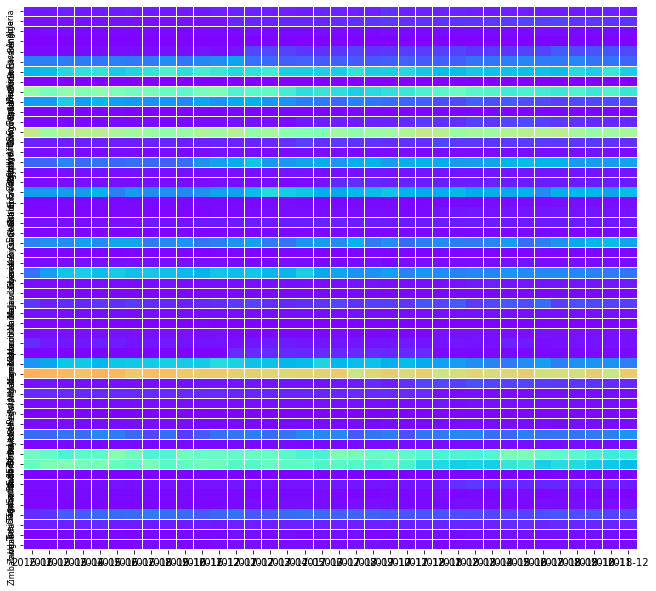

In [71]:
#@TODO: Use os.path.join to make paths, not strings and trailing /
for ensemble in ensembles_cm:
    for step in ensemble["steps"]:
        # Prepare params and data.
        col_ss = ensemble["col_ebma_ss"][step]
        country = eval_data.fetch_country()
        probs = pd.DataFrame(df_cm_b[col_ss])
        probs.reset_index(inplace=True)
        df = probs.merge(country, on="country_id")
        # Note that the function works with unindexed data.
        eval_plot.plot_heatmap(
            df=df,
            colname_feature=col_ss,
            level="cm",
            variable_scale="prob",
            to_path=f"{dir_plots_heatmaps_cm}/",
            run="r_2020_02_01",
        )

priogrid = eval_data.fetch_priogrid()
for ensemble in ensembles_pgm:
    for step in ensemble["steps"]:
        # Prepare params and data.
        col_ss = ensemble["col_avg_ss"][step]
        country = eval_data.fetch_country()
        probs = pd.DataFrame(df_pgm_b[col_ss])
        probs.reset_index(inplace=True)
        probs = probs.merge(priogrid, on="pg_id")
        df = probs.merge(country, on="country_id")
        # Note that the function works with unindexed data.
        eval_plot.plot_heatmap(
            df=df,
            colname_feature=col_ss,
            level="pgm",
            variable_scale="logodds",
            to_path=f"{dir_plots_heatmaps_pgm}/",
            run="r_2020_02_01",
        )

## ACTUALS

In [ ]:
# Actuals heatmaps
priogrid = eval_data.fetch_priogrid()
for outcome in ["sb", "ns", "os"]:
    col_actual = f"ged_dummy_{outcome}"
    actuals = pd.DataFrame(df_pgm_b[col_actual])
    country = eval_data.fetch_country()
    actuals.reset_index(inplace=True)
    actuals = actuals.merge(priogrid, on="pg_id")
    df = actuals.merge(country, on="country_id")
    # Note that the function works with unindexed data.
    eval_plot.plot_heatmap(
        df=df,
        colname_feature=col_actual,
        level="pgm",
        run="Country proportions",
        variable_scale="logodds",
        to_path=f"{dir_plots_heatmaps_cm}/",
    )

In [ ]:
# Map of actuals (decay)
for outcome in ["sb", "ns", "os"]:
    col = f"decay_12_cw_ged_dummy_{outcome}_0"
    for t in [480]:
        df = dbutils.db_to_df(
            fqtable="launched.transforms_pgm_imp_1",
            columns=[col],
            ids=["month_id", "pg_id"],
        )
        date_str = mapdata.df_m.loc[t, "date_str"]
        fancy.plot_map(
            mapdata=mapdata,
            s_patch=df[col],
            t=t,
            run_id="Conflict history at 2019-12",
            # title=f"{pgm_column}, {date_str}",
            logodds=False,
            path=os.path.join(dir_plots_maps_pgm, f"{col}_{t}.png"),
            bbox="mainland_africa",
            textsize=18
        )


## Feature importances
Unfortunately getting feature importances forced me to rsync the full run to my local dir_runs and get the feature importances here, which makes this part not portable and so redo_featimp is False by default. 
The feature importances are in the database though so running these cells will get them to featimps_cm_c and featimps_pgm_c contain a list of feature importance dicts.

In [ ]:
def persist_featimps(featimps, fqtable):
    q_create = f"DROP TABLE IF EXISTS {fqtable}; CREATE TABLE {fqtable} (featimp JSON);"
    dbutils.execute_query(q_create)
    for featimp in featimps:
        q_insert = f"INSERT INTO {fqtable} (featimp) VALUES (:featimp)"
        params = {"featimp": json.dumps(featimp)}
        dbutils.execute_query(q_insert, **params)

def get_featimps_from_db(fqtable):
    rows = dbutils.get_query_rows(f"SELECT * FROM {fqtable};")
    return [row["featimp"] for row in rows]

In [ ]:
%%time
# Instead of the get_feature_importances_remote() call, which is portable but very slow
# rsync the full run to your local machine and run this local version instead.
# Writes the feature importances to the database 
if redo_featimp:
    dir_runs = config.CONFIG["dirs"]["dir_runs"]
    featimps_cm_c = fi.get_feature_importances_par(os.path.join(dir_runs, "cm_r_2020_02_02"))
    persist_featimps(featimps_cm_c, "newpipe.featimps_cm_c")
    featimps_pgm_c = fi.get_feature_importances_par(os.path.join(dir_runs, "pgm_r_2020_02_02"))
    persist_featimps(featimps_pgm_c, "newpipe.featimps_pgm_c")

In [ ]:
def fix_global_featimp_names(featimps):
    basemodels = ["vdem", "reign", "wdi_all", "all"]
    featimps = copy.deepcopy(featimps)
    for bm in basemodels:
        for outcome in ["sb", "ns", "os"]:
            oldname = f"{bm}_{outcome}"
            newname = f"{outcome}_{bm}_glob"
            for featimp in featimps:
                name, step = featimp["name"].split(".")
                if name == oldname:
                    featimp["name"] = f"{newname}.{step}"
    return featimps

def fix_misc_featimp_names(featimps):
    renames = {
        "sbonset24_" : "sb_onset24_",
        "nsonset24_" : "ns_onset24_",
        "osonset24_" : "os_onset24_",
        "sb100_all": "sb_100_all",
        "ns100_all": "ns_100_all",
        "os100_all": "os_100_all",
    }
    for featimp in featimps:
        for key, value in renames.items():
            featimp["name"] = featimp["name"].replace(key, value)
    return featimps

In [ ]:
# Get featimps from db
featimps_cm_c = get_featimps_from_db("newpipe.featimps_cm_c")
featimps_pgm_c = get_featimps_from_db("newpipe.featimps_pgm_c")
featimps_cm_c_global = get_featimps_from_db("newpipe.featimps_cm_c_global")

# Fix names
featimps_cm_c_global = fix_global_featimp_names(featimps_cm_c_global)
featimps_cm_c = fix_misc_featimp_names(featimps_cm_c)

featimps_cm_c = featimps_cm_c + featimps_cm_c_global

In [ ]:
def organise_featimp_by_model(featimps, namestrips):
    featimps_by_model = dict()
    for featimp in featimps:
        name, step = featimp_name_and_step(featimp, namestrips)
        step = int(step)

        if name not in featimps_by_model.keys():
            featimps_by_model[name] = dict()

        featimps_by_model[name][step] = featimp["feature_importances"]

    return featimps_by_model

def featimp_name_and_step(featimp, namestrips):
    # Get the model name
    name = featimp["name"]
    # Strip out namestrips if any passed
    if namestrips:
        for ns in namestrips:
            name = name.replace(ns, "")

    # Escape underscores in name
    name, step = name.split(".")
    return name, step

In [ ]:
namestrips = ["_rf_shift_fewsteps", "cm_africa_1_C_train.", "pgm_africa_1_C_train.",]
featimps_cm_c_by_model = organise_featimp_by_model(featimps_cm_c, namestrips)
featimps_pgm_c_by_model = organise_featimp_by_model(featimps_pgm_c, namestrips)
# Assign the featimps to the model dicts
for model in models_cm:
    if model["name"] in featimps_cm_c_by_model:
        model["featimps"] = featimps_cm_c_by_model[model["name"]]
    else:
        model["featimps"] = dict()
        print(f"No match for {model['name']}")

for model in models_pgm:
    if model["name"] in featimps_pgm_c_by_model:
        model["featimps"] = featimps_pgm_c_by_model[model["name"]]
    else:
        model["featimps"] = dict()
        print(f"No match for {model['name']}")

In [ ]:
def featimps_to_tex_str(featimps, name, limit_rows=25):
    df = pd.DataFrame(featimps)
    df = df.sort_values([1], ascending=False)
    df = df.iloc[0:limit_rows]
    tex = df.to_latex()
    name_escaped = model['name'].replace("_", "\_")
    tex = tex.replace("{} & ", f"{name_escaped} &")
    return tex


for model in models_cm:
    if model["featimps"]:
        tex_str = featimps_to_tex_str(model["featimps"], model["name"])
        path = os.path.join(dir_tables_featimp_cm, f"{model['name']}.tex")
        pyutils.write_str(tex_str, path)

for model in models_pgm:
    if model["featimps"]:
        tex_str = featimps_to_tex_str(model["featimps"], model["name"])
        path = os.path.join(dir_tables_featimp_pgm, f"{model['name']}.tex")
        pyutils.write_str(tex_str, path)
        

## Delta maps, fcast (c)

In [ ]:
run_id = "r_2020_02_01"

for ensemble in ensembles_cm:
    # Get current (2019) ensemble predictions.
    outcome = ensemble["outcome"]
    current = eval_data.fetch_ensemble_predictions(
        run_id=run_id, level="cm", outcome=outcome, eval_test=False
    )
    col_current = current.columns[0]
    for step in ensemble["steps"]:
        # Prepare params and slice data.
        col_ss = ensemble["col_ebma_ss"][step]
        month_index = df_cm_c.index.get_level_values(0).unique()[step]
        probs = df_cm_c.loc[slice(month_index, month_index), :][col_ss]
        ens_current = current.loc[slice(month_index, month_index), :]
        # Merge and get delta.
        df_cm_delta = ens_current.join(probs)
        col_a = df_cm_delta.columns[0]
        col_b = df_cm_delta.columns[1]
        df_cm_delta["delta"] = df_cm_delta[col_b] - df_cm_delta[col_a]
        # Plot.
        vmin, vmax = -0.5, 0.5
        fancy.plot_map(
            mapdata=mapdata,
            logodds=False,
            run_id=run_id,
            path=os.path.join(dir_plots_deltas_cm, f"{outcome}_{step}.png"),
            fig_scale=0.5,
            cmap="seismic",
            vmin=vmin,
            vmax=vmax,
            s_patch=df_cm_delta["delta"],
            t=month_index,
            size_gridborder=0,
            title=f"New ensemble {run_id} (s={step}) - old ensemble {run_id} (s={step})",
            bbox="mainland_africa",
            textsize=18
        )


for ensemble in ensembles_pgm:
    # Get current (2019) ensemble predictions.
    outcome = ensemble["outcome"]
    current = eval_data.fetch_ensemble_predictions(
        run_id=run_id, level="pgm", outcome=outcome, eval_test=False
    )
    col_current = current.columns[0]
    for step in ensemble["steps"]:
        # Prepare params and slice data.
        col_ss = ensemble["col_avg_ss"][step]
        month_index = df_pgm_c.index.get_level_values(0).unique()[step]
        probs = df_pgm_c.loc[slice(month_index, month_index), :][col_ss]
        ens_current = current.loc[slice(month_index, month_index), :]
        # Merge and get delta.
        df_pgm_delta = ens_current.join(probs)
        col_a = df_pgm_delta.columns[0]
        col_b = df_pgm_delta.columns[1]
        df_pgm_delta["delta"] = df_pgm_delta[col_b] - df_pgm_delta[col_a]
        # Plot.
        vmin, vmax = -0.5, 0.5
        fancy.plot_map(
            mapdata=mapdata,
            logodds=False,
            run_id=run_id,
            path=os.path.join(dir_plots_deltas_pgm, f"{outcome}_{step}.png"),
            fig_scale=0.5,
            cmap="seismic",
            vmin=vmin,
            vmax=vmax,
            s_patch=df_pgm_delta["delta"],
            t=month_index,
            size_gridborder=0,
            title=f"New ensemble {run_id} (s={step}) - old ensemble {run_id} (s={step})",
            bbox="mainland_africa",
            textsize=18
        )

## Feature maps

In [ ]:
# Plot the three time scales of spacetime feature for SB
cols_features_pgm = [
    "stdist_k1_t001_ged_dummy_sb",
    "stdist_k1_t10_ged_dummy_sb",
    "stdist_k1_t1_ged_dummy_sb",
]
df_pgm_features = dbutils.db_to_df(fqtable="flat.pgm_africa_1", ids=["month_id", "pg_id"], columns=cols_features_pgm)

### Space-time

In [ ]:
# Plot three space-time maps for the three different time scales
fancy.plot_stdist(
    df=df_pgm_features, 
    col="stdist_k1_t001_ged_dummy_sb", 
    t=468, 
    mapdata=mapdata, 
    title="Spacetime distance, sb, 2018-12, t-scale=0.01", 
    path=os.path.join(dir_plots_maps_pgm, "sb_stdist_t001_468.png")
)
fancy.plot_stdist(
    df=df_pgm_features, 
    col="stdist_k1_t1_ged_dummy_sb", 
    t=468, 
    mapdata=mapdata, 
    title="Spacetime distance, sb, 2018-12, t-scale=1.0", 
    path=os.path.join(dir_plots_maps_pgm, "sb_stdist_t1_468.png")
)
fancy.plot_stdist(
    df=df_pgm_features, 
    col="stdist_k1_t10_ged_dummy_sb", 
    t=468, 
    mapdata=mapdata, 
    title="Spacetime distance, sb, 2018-12, t-scale=10.0", 
    path=os.path.join(dir_plots_maps_pgm, "sb_stdist_t10_468.png")
)

In [ ]:
notebook_timer_end = time.time()
total_runtime = notebook_timer_end - notebook_timer_start
print(f"Total runtime: {total_runtime} seconds")